In [1]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
import numpy as np
import pandas as pd
from time import time
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, lit, min, max, mean, stddev
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans

from ucimlrepo import fetch_ucirepo 
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

from cdc_module import spark_histograms, clean_data, validity_check, calculate_correlation, heatmap, feature_correlation, \
target_histograms, select_corr_features, pca_filter, plot_principal_components, plot_principal_components_3d, plot_pca_with_clusters, \
      plot_eigenvalues, test_train_split, fit_and_test, plot_absolute_contributions, plot_models_results


/home/lyudmil/anaconda3/envs/big_data/lib/python3.8/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## **1.Data Undestanding**

#### 1.1 Dataset Overview

In [2]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features[:1000]
y = cdc_diabetes_health_indicators.data.targets[:1000]


In [3]:
X, y = clean_data(X, y)

In [4]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CDC Diabetes Health Indicators") \
    .master('local[16]') \
    .config("spark.driver.memory", "16g")\
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Converting a pandas DataFrame to a PySpark DataFrame
# X is the feature, y is the target variable
X_pyspark = spark.createDataFrame(X)
y_pyspark = spark.createDataFrame(y)
spark

24/10/13 18:53:42 WARN Utils: Your hostname, lyudmil-ROG-Zephyrus-M16-GU603ZX-GU603ZX resolves to a loopback address: 127.0.1.1; using 192.168.1.16 instead (on interface wlo1)
24/10/13 18:53:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/13 18:53:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/13 18:53:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
ps_x = X_pyspark.pandas_api()
ps_y = y_pyspark.pandas_api()
ps_x.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000
mean,0.465215,0.451906,0.961081,28.602642,0.453519,0.047288,0.101633,0.741278,0.601835,0.801775,0.055455,0.939201,0.108086,2.608187,3.560294,4.807421,0.197116,0.417221,8.121597,4.999093,5.903105
std,0.498814,0.497707,0.193412,6.341075,0.497860,0.212264,0.302181,0.437954,0.489544,0.398683,0.228877,0.238972,0.310505,1.102557,7.869585,9.211771,0.397841,0.493125,3.000779,0.994539,2.127334
min,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,4.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,4.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,74.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [8]:
ps_y.describe()

,Diabetes_binary
count,9918.000000
mean,0.161424
std,0.367940
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


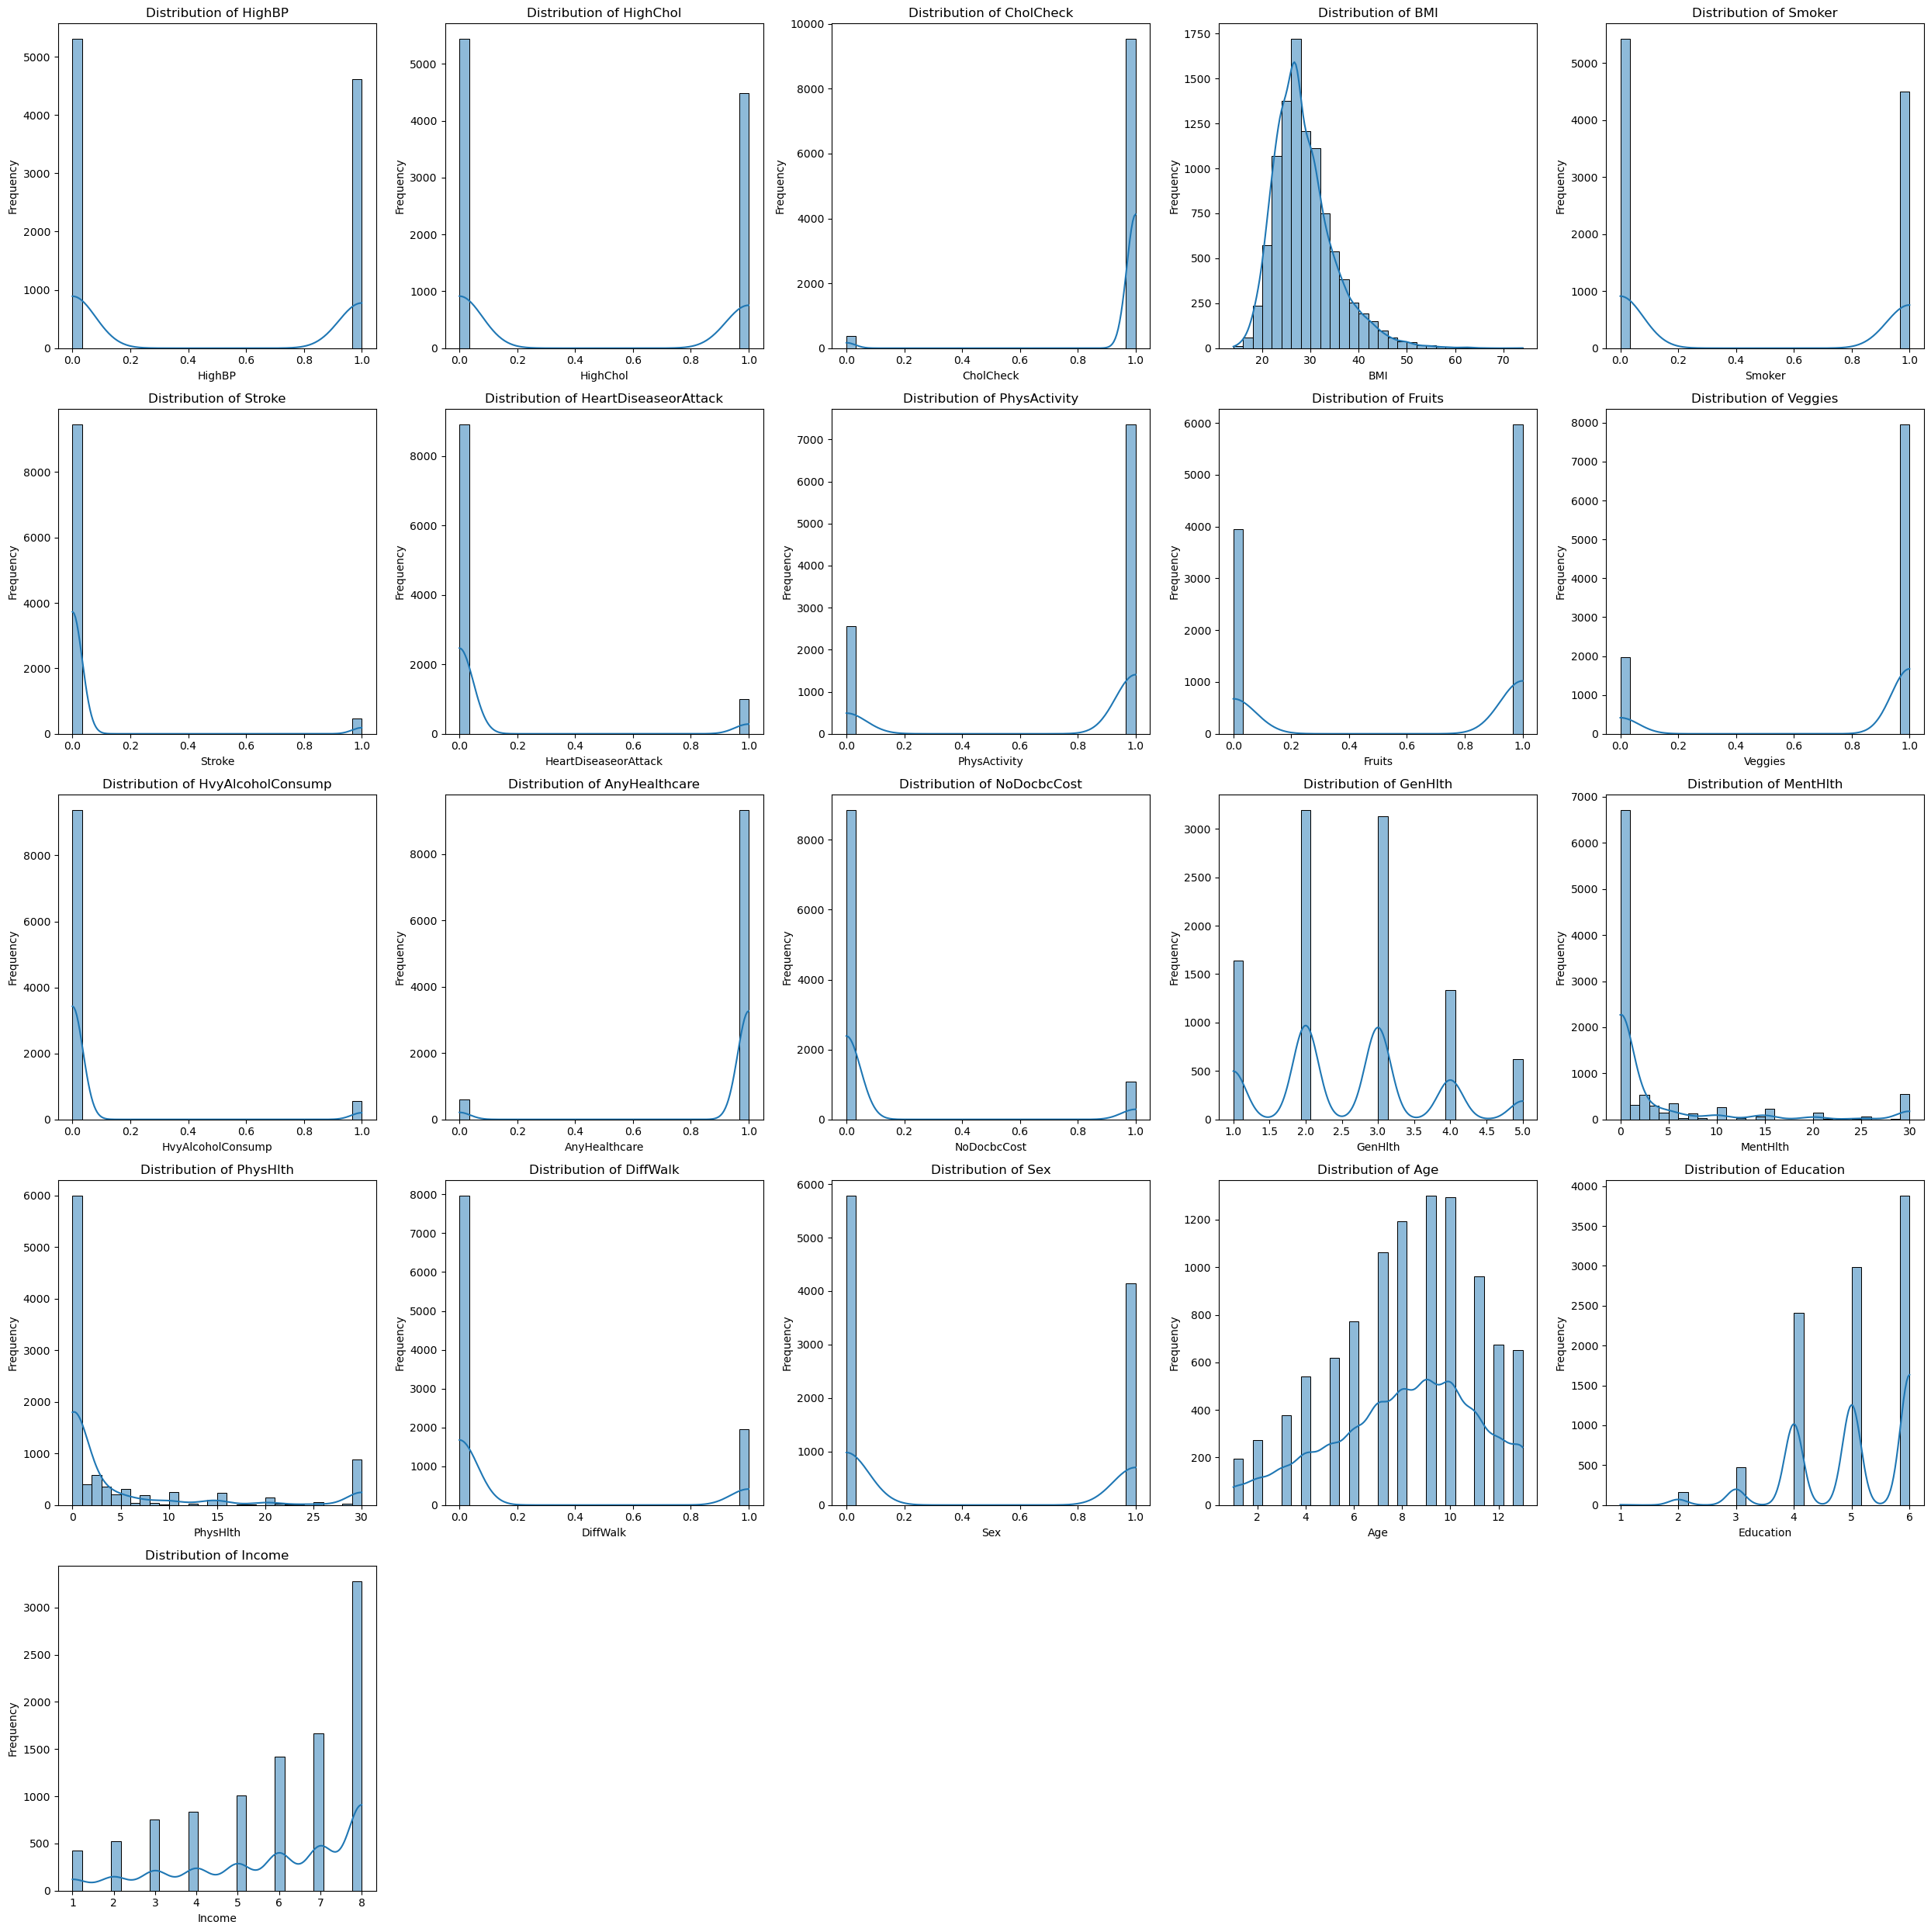

In [9]:
spark_histograms(X_pyspark)

## **2.Data Preprocessing**

#### 2.1 Validity Check

In [8]:
validity_check(X_pyspark)

Feature 'HighBP' has 0 invalid entries.
Feature 'HighChol' has 0 invalid entries.
Feature 'CholCheck' has 0 invalid entries.
Feature 'Smoker' has 0 invalid entries.
Feature 'Stroke' has 0 invalid entries.
Feature 'HeartDiseaseorAttack' has 0 invalid entries.
Feature 'PhysActivity' has 0 invalid entries.
Feature 'Fruits' has 0 invalid entries.
Feature 'Veggies' has 0 invalid entries.
Feature 'HvyAlcoholConsump' has 0 invalid entries.
Feature 'AnyHealthcare' has 0 invalid entries.
Feature 'NoDocbcCost' has 0 invalid entries.
Feature 'GenHlth' has 0 invalid entries.
Feature 'MentHlth' has 0 invalid entries.
Feature 'PhysHlth' has 0 invalid entries.
Feature 'DiffWalk' has 0 invalid entries.
Feature 'Sex' has 0 invalid entries.
Feature 'Age' has 0 invalid entries.
Feature 'Education' has 0 invalid entries.
Feature 'Income' has 0 invalid entries.


#### 2.2 Features Understanding(aggregation index)

In [5]:
# Summing Fruits and Veggies to indicate the healthiness of a diet
# Summing HighChol and HighBP to indicate overall cardiovascular risk
# Summing Smoker and HvyAlcoholConsump to indicate healthcare accessibility

X_pyspark = X_pyspark.withColumn('Diet', F.col('Fruits') + F.col('Veggies'))

X_pyspark = X_pyspark.withColumn('cardiovascular', F.col('HighChol')  + F.col('HighBP'))

X_pyspark = X_pyspark.withColumn('unhealthy_behavior', F.col('Smoker') + F.col('HvyAlcoholConsump'))

In [6]:
# 0：no healthcare and with cost problem。
# 1：no healthcare and no cost problem。
# 2：with healthcare but with cost problem。
# 3：with healthcare and no cost problem。

X_pyspark = X_pyspark.withColumn('healthcare',
    F.when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 0), 3)
     .when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 1), 2)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 0), 1)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 1), 0)
     .otherwise(-1))


#### 2.3 Data Transformation

In [7]:
# Min-Max Scaling: GenHlth, Age, Education, Income, BMI, MentHlth, PhysHlth, Diet, cardiovascular, unhealthy_behavior, healthcare
min_max_features = ["GenHlth", "Age", "Education", "Income", "BMI", "MentHlth", "PhysHlth", "Diet", "cardiovascular", "unhealthy_behavior", "healthcare"]

for feature in min_max_features:
    min_val = X_pyspark.agg(min(col(feature))).collect()[0][0]
    max_val = X_pyspark.agg(max(col(feature))).collect()[0][0]
    X_pyspark = X_pyspark.withColumn(
        feature,
        (col(feature) - min_val) / (max_val - min_val)
    )



In [8]:
X_pyspark.show(2)

+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+------------------+---------+------------------+----+--------------+------------------+----------+
|HighBP|HighChol|CholCheck|                BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|               Age|Education|            Income|Diet|cardiovascular|unhealthy_behavior|healthcare|
+------+--------+---------+-------------------+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+------------------+---------+------------------+----+--------------+------------------+----------+
|     1|       1|        1|0.43333333333333335|     1|     0|                   0|           0|     0|      1|              

#### 2.4 Class Imbalance

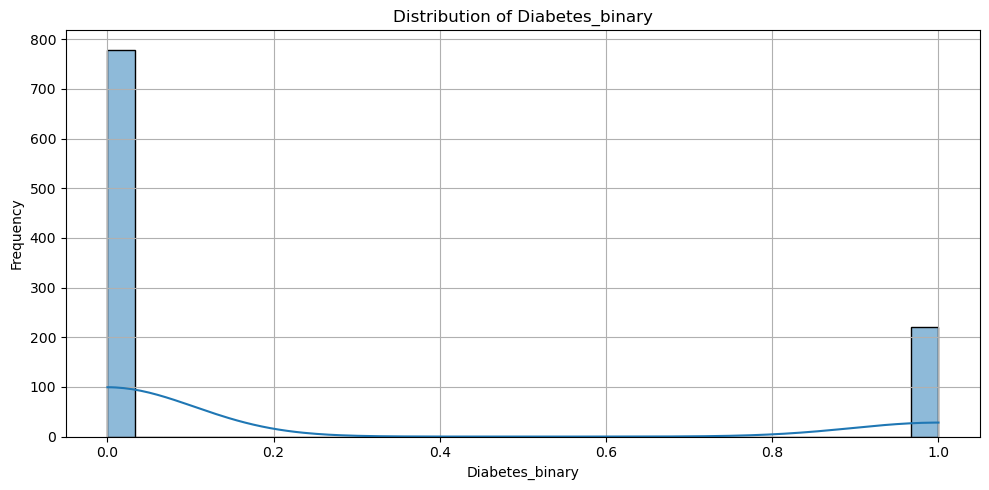

In [8]:
target_histograms(y_pyspark)

In [9]:
# Display original counts of classes
original_counts = y_pyspark.groupBy('Diabetes_binary').count().collect()

# Get counts of each class
count_0 = next(count['count'] for count in original_counts if count['Diabetes_binary'] == 0)
count_1 = next(count['count'] for count in original_counts if count['Diabetes_binary'] == 1)
print(f"Original class distribution: class 0 - {count_0}; class 1 - {count_1}")

# Print the counts
print(f"Number of zeros (0s): {count_0}")
print(f"Number of ones (1s): {count_1}")

# Undersample the majority class (0s) to match the count of the minority class (1s)
majority_class = y_pyspark.filter(F.col('Diabetes_binary') == 0)
undersampled_majority = majority_class.sample(withReplacement=False, fraction=count_1 / count_0)

# Add an ID column to the original y_pyspark DataFrame for indexing
y_pyspark_with_id = y_pyspark.withColumn("id", F.monotonically_increasing_id())

# Combine the undersampled majority class with the minority class (1s)
minority_class = y_pyspark.filter(F.col('Diabetes_binary') == 1)

# Combine the DataFrames
balanced_y = undersampled_majority.union(minority_class)

# Add an ID column to the balanced y DataFrame for indexing
balanced_y_with_id = balanced_y.withColumn("id", F.monotonically_increasing_id())

# Align X_pyspark with balanced_y
# Add ID column to X_pyspark for indexing
X_pyspark_with_id = X_pyspark.withColumn("id", F.monotonically_increasing_id())

# Filter X_pyspark based on the indices of the balanced_y
balanced_X = X_pyspark_with_id.join(balanced_y_with_id, "id").drop("id")

# Optionally, shuffle the balanced DataFrames
y_pyspark = balanced_y.orderBy(F.rand())
X_pyspark = balanced_X.orderBy(F.rand())

# Display the new class distribution
balanced_counts = y_pyspark.groupBy('Diabetes_binary').count().collect()
count_0 = next(count['count'] for count in balanced_counts if count['Diabetes_binary'] == 0)
count_1 = next(count['count'] for count in balanced_counts if count['Diabetes_binary'] == 1)
print(f"Balanced class distribution: class 0 - {count_0}; class 1 - {count_1}")



Original class distribution: class 0 - 779; class 1 - 221
Number of zeros (0s): 779
Number of ones (1s): 221
Balanced class distribution: class 0 - 219; class 1 - 221


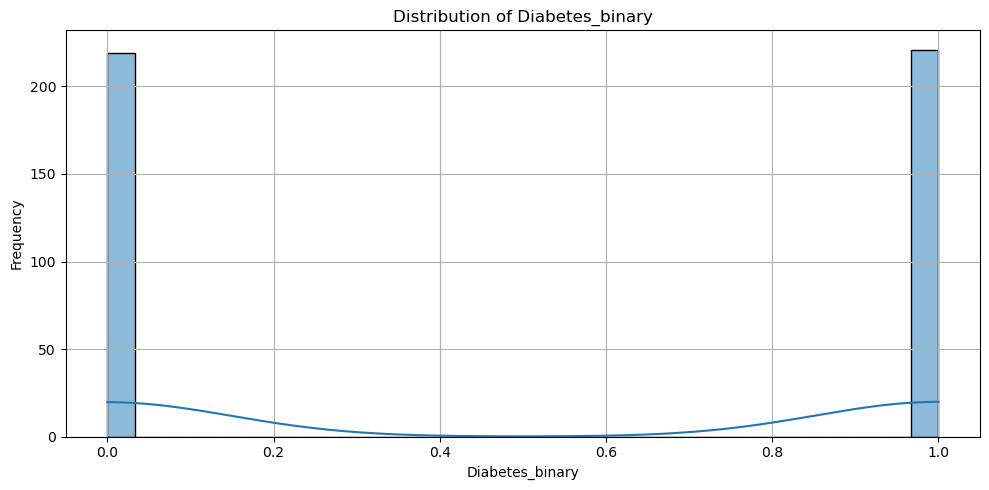

In [10]:
target_histograms(y_pyspark)

In [11]:
X_with_all_features = X_pyspark
# Dropping individual columns that are part of aggregated metrics
X_pyspark = X_pyspark.drop('Fruits', 'Veggies', 'HighChol', 'HighBP', 'Smoker', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost')

## **3.Exploratory Data Analysis (EDA)**

#### 3.1 Descriptive Statistics

In [15]:
# Convert back to pandas-on-Spark DataFrame
ps_x = X_pyspark.pandas_api()

ps_x.describe()

,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diet,cardiovascular,unhealthy_behavior,healthcare
count,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000,9918.000000
mean,0.961081,0.243377,0.047288,0.101633,0.741278,0.402047,0.118676,0.160247,0.197116,0.417221,0.593466,0.799819,0.700444,0.701805,0.458560,0.254487,0.923439
std,0.193412,0.105685,0.212264,0.302181,0.437954,0.275639,0.262319,0.307059,0.397841,0.493125,0.250065,0.198908,0.303905,0.354225,0.399274,0.284410,0.211720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.166667,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.416667,0.600000,0.428571,0.500000,0.000000,0.000000,1.000000
50%,1.000000,0.216667,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.583333,0.800000,0.714286,1.000000,0.500000,0.000000,1.000000
75%,1.000000,0.300000,0.000000,0.000000,1.000000,0.500000,0.066667,0.133333,0.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Plotting the distribution of all indicators

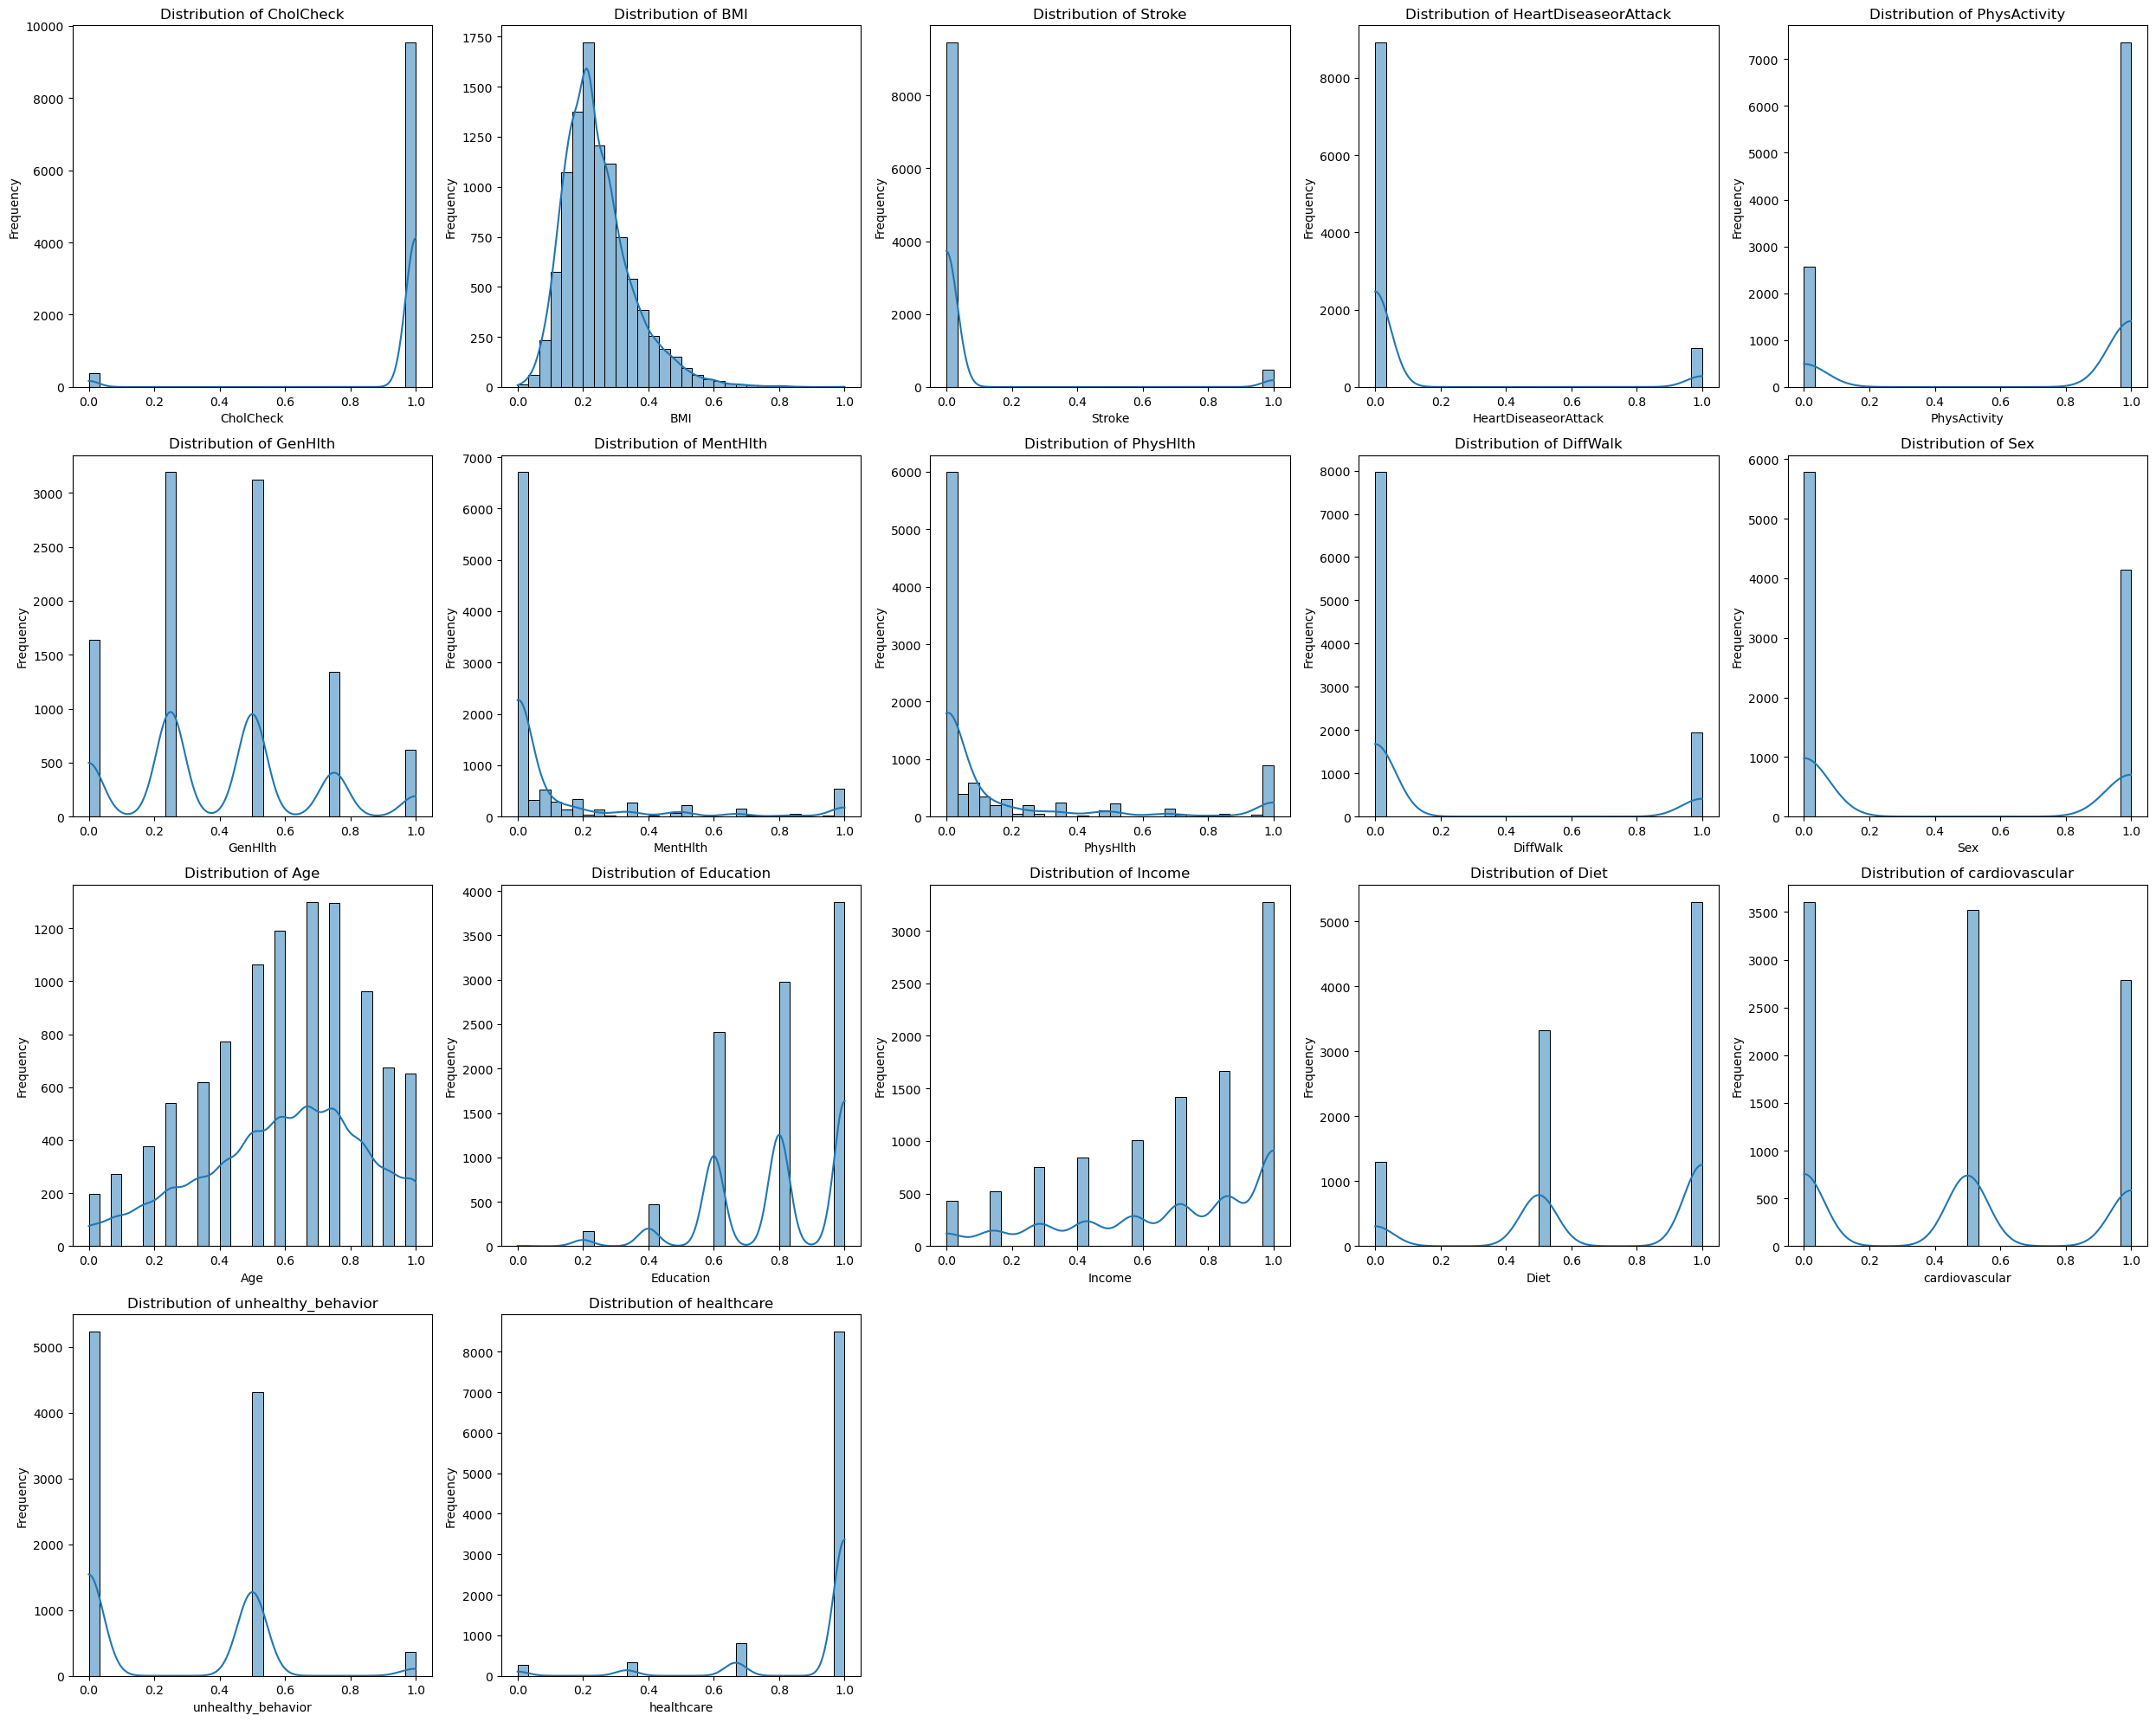

In [16]:
spark_histograms(X_pyspark)

#### 3.2 Correlation Analysis

In [17]:
correlation_df, joined_df = calculate_correlation(X_pyspark, y_pyspark)

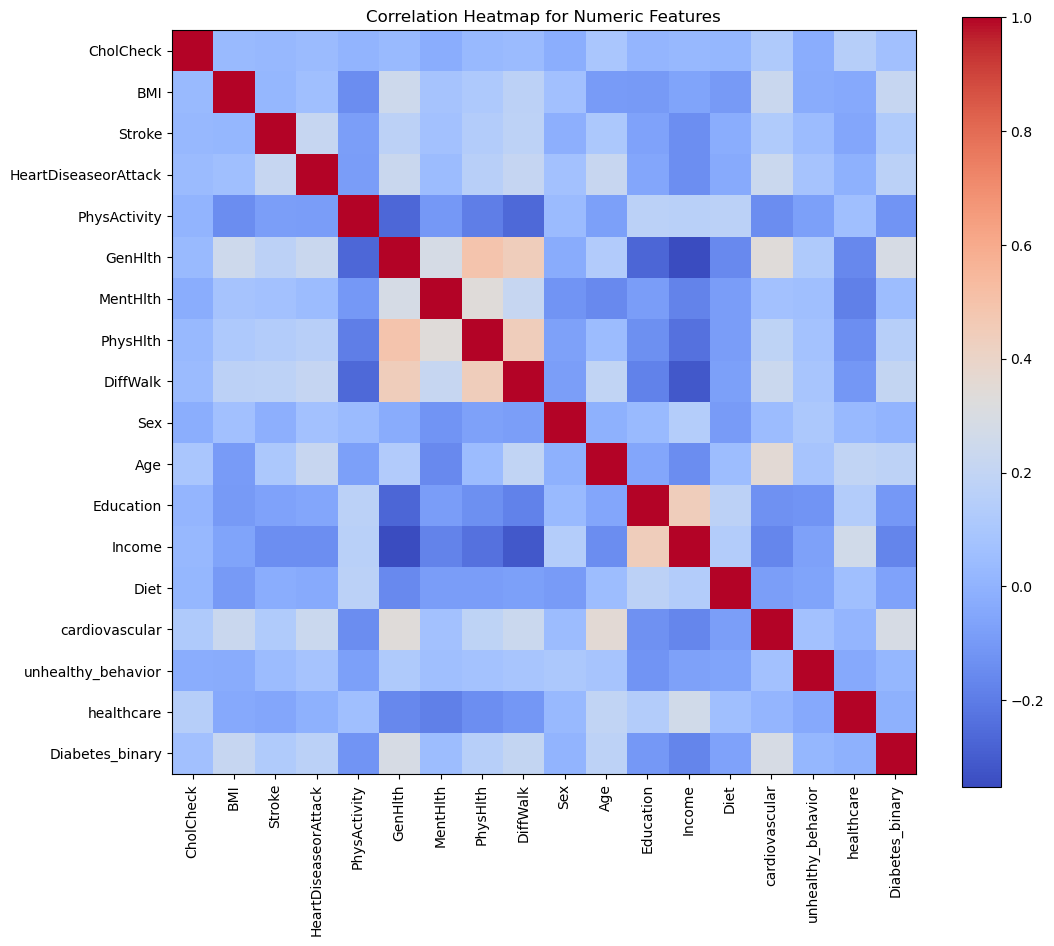

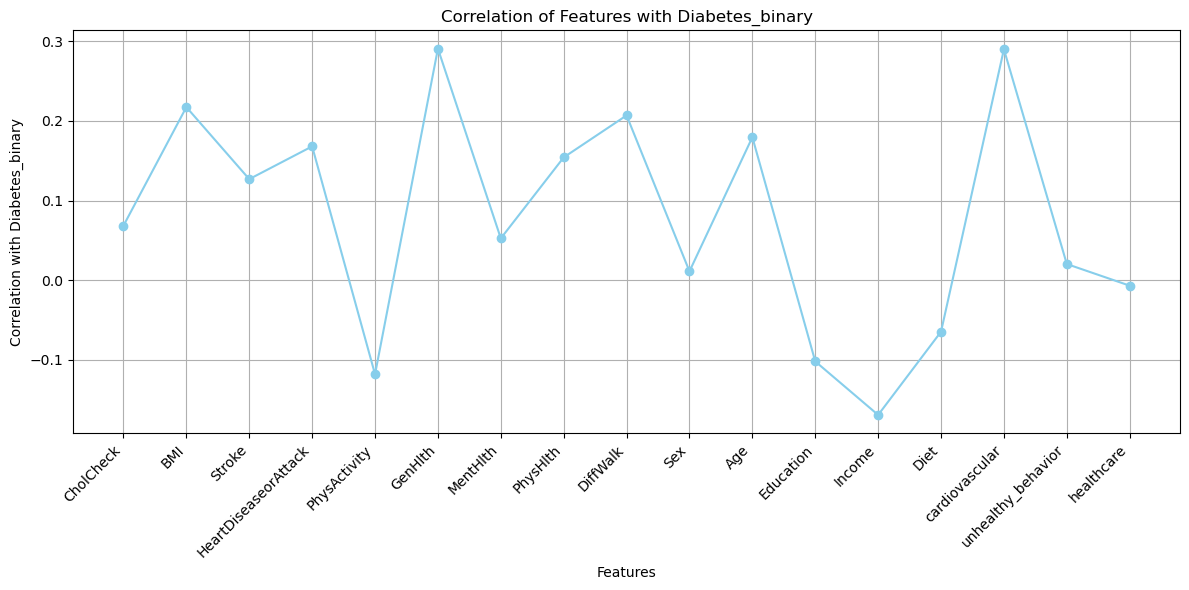

In [18]:
# Collecting data from a Spark DataFrame to a local list
correlation_data = correlation_df.collect()

heatmap(correlation_data, joined_df)
feature_correlation(correlation_data, joined_df)

#### 3.3 Bivariate Analysis

In [19]:
selected_columns = select_corr_features(correlation_df)

Features with correlation greater than 0.2 with Diabetes_binary:
['BMI', 'GenHlth', 'DiffWalk', 'cardiovascular']


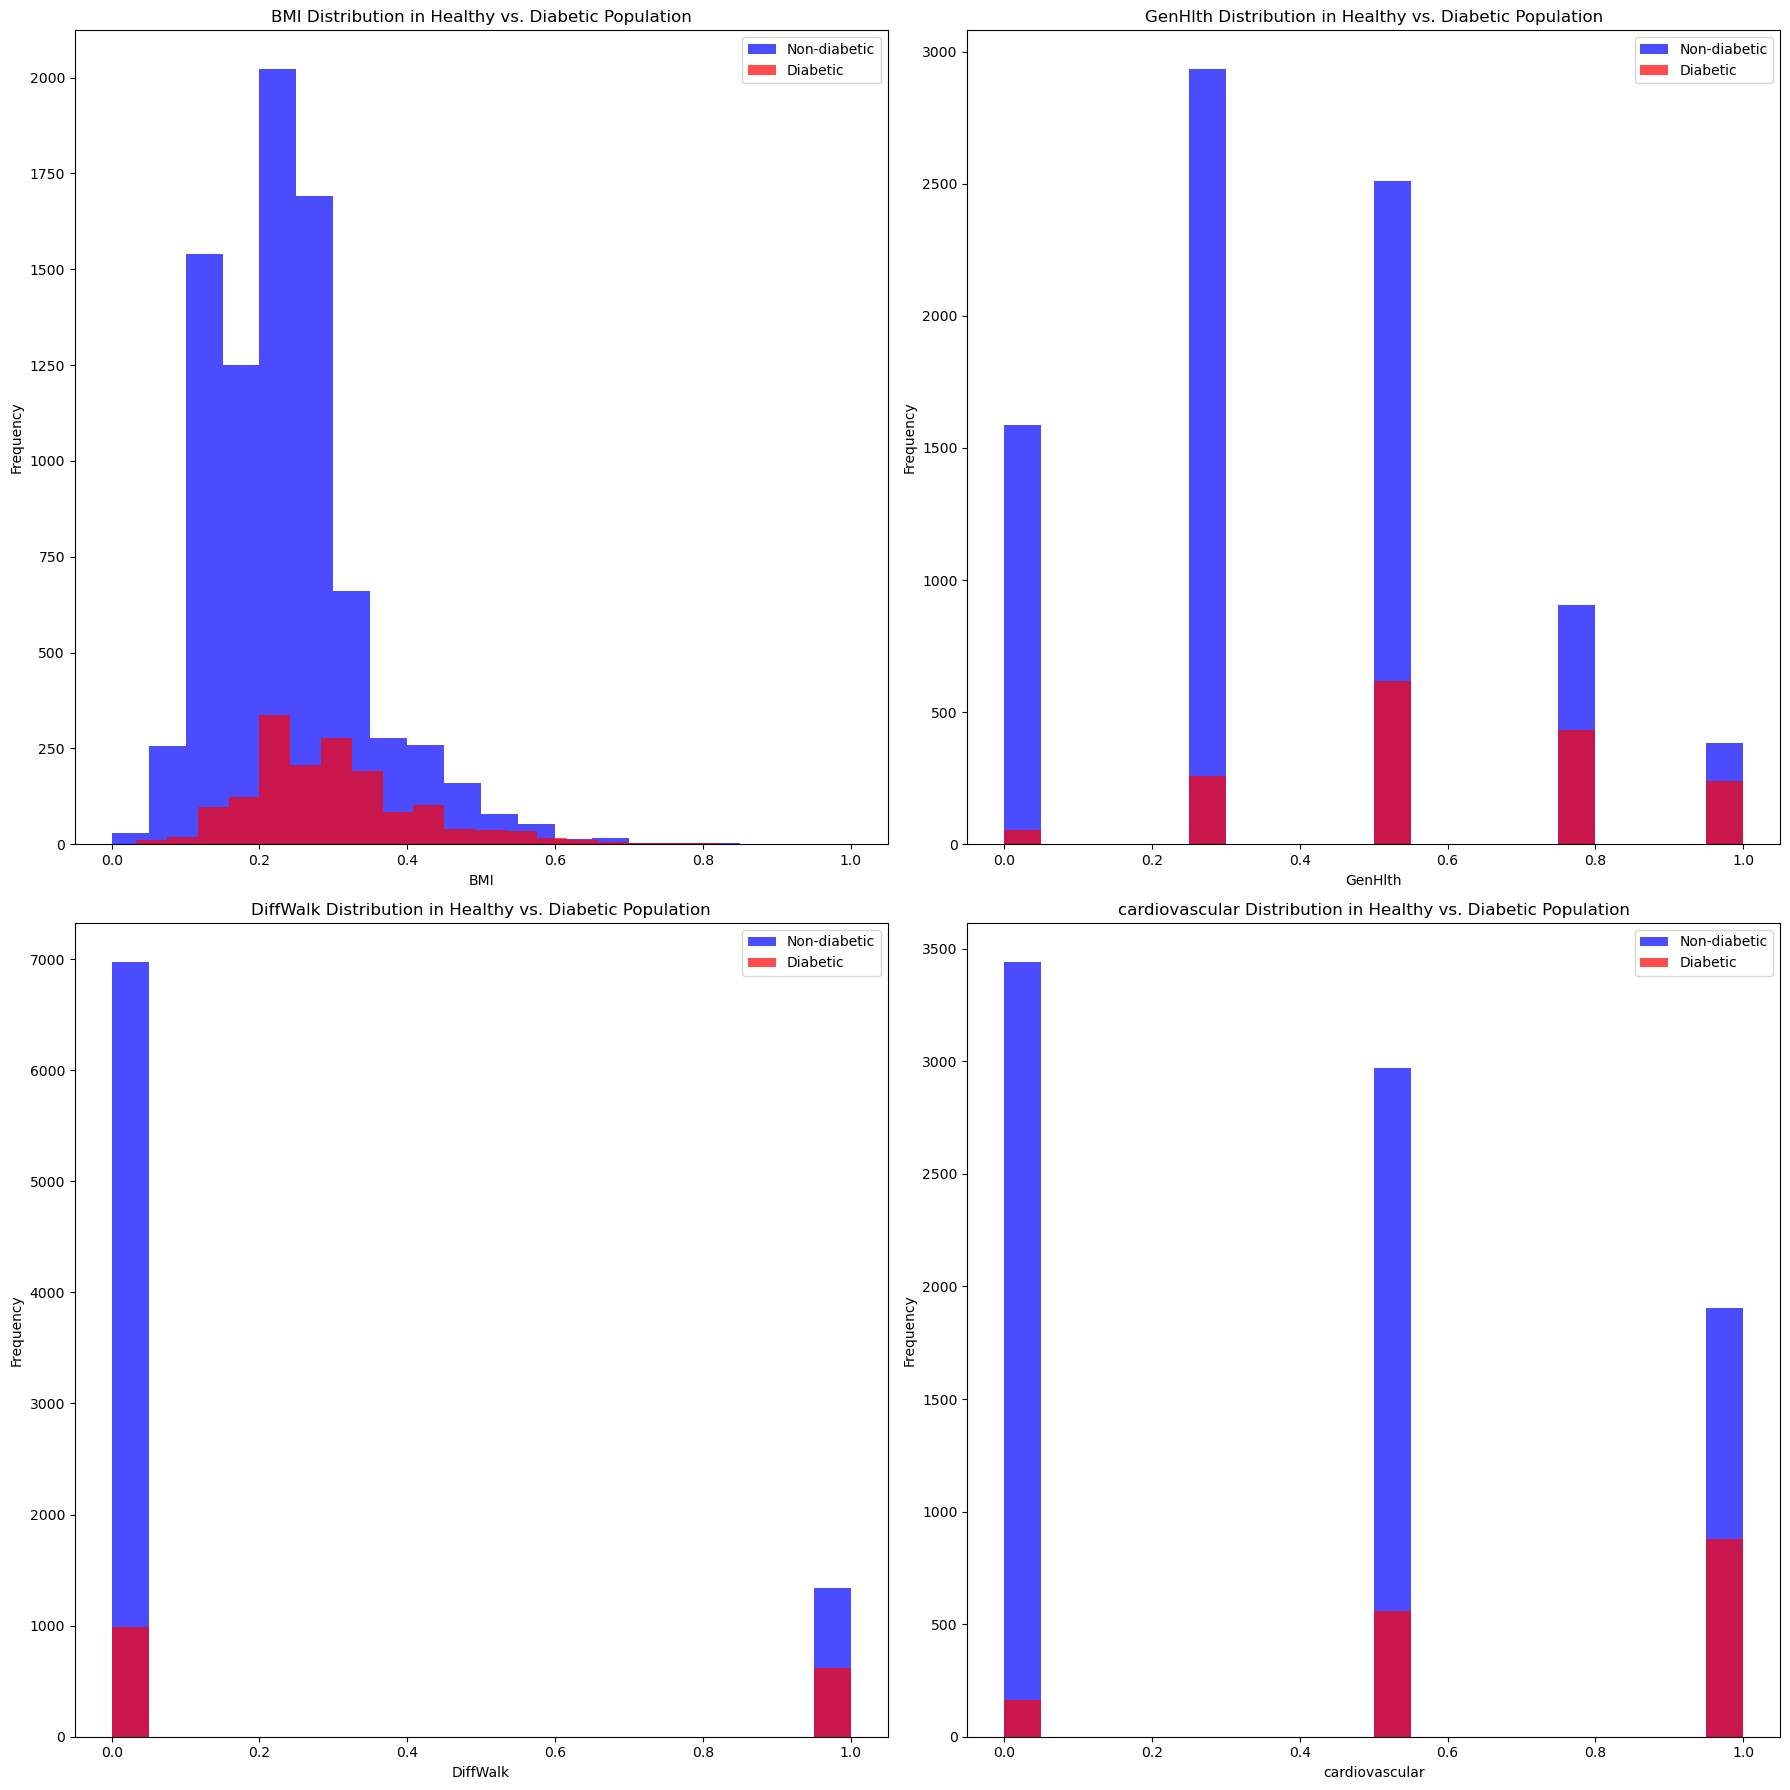

In [20]:
# Selection of features and target variables of interest
selected_df = joined_df.select(selected_columns)

# Collecting data to the local environment
data = selected_df.collect()

# Converting collected data to Python lists
bmi = [row['BMI'] for row in data]
gen_hlth = [row['GenHlth'] for row in data]
diff_walk = [row['DiffWalk'] for row in data]
cardiovascular = [row['cardiovascular'] for row in data]
diabetes_binary = [row['Diabetes_binary'] for row in data]

# Plot histograms of each characteristic separately, grouped by whether they have diabetes or not
features = {
    'BMI': bmi,
    'GenHlth': gen_hlth,
    'DiffWalk': diff_walk,
    'cardiovascular': cardiovascular
}

plt.figure(figsize=(18, 18))

for idx, (feature_name, feature_data) in enumerate(features.items()):
    # Grouping of data by presence or absence of diabetes
    diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 1]
    non_diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 0]
    
    # Plotting histograms for each feature
    plt.subplot(2, 2, idx + 1)
    plt.hist(non_diabetic_data, bins=20, alpha=0.7, label='Non-diabetic', color='b')
    plt.hist(diabetic_data, bins=20, alpha=0.7, label='Diabetic', color='r')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'{feature_name} Distribution in Healthy vs. Diabetic Population')
    plt.legend()

plt.tight_layout()
plt.show()

#### 3.4 Chi-square Tests

In [21]:
# Combine X and y into a single DataFrame
data_pyspark = X_pyspark.join(y_pyspark)

# Combine the features into a single vector column for ChiSquareTest
vector_assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
data_vector = vector_assembler.transform(data_pyspark)

# Run the Chi-square test on the features and the target variable
chi_square_result = ChiSquareTest.test(data_vector, "features", "Diabetes_binary")

# Show the results
chi_square_result.show(truncate=False)

+---------------------------------------------------------------------+-------------------------------------------------------+---------------------------------------------------------------------+
|pValues                                                              |degreesOfFreedom                                       |statistics                                                           |
+---------------------------------------------------------------------+-------------------------------------------------------+---------------------------------------------------------------------+
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]|[1, 51, 1, 1, 1, 4, 30, 30, 1, 1, 12, 5, 7, 2, 2, 2, 3]|[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]|
+---------------------------------------------------------------------+-------------------------------------------------------+---------------------------------------------------------------------+



In [22]:
data_pandas = data_pyspark.toPandas()

X = data_pandas.drop('Diabetes_binary', axis=1)  
y = data_pandas['Diabetes_binary'] 

f_values, p_values = f_classif(X, y)

anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'p-value': p_values
})

Py4JJavaError: An error occurred while calling o2101.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1._next(SparkPlan.scala:415)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:426)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.getNext(SparkPlan.scala:412)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$4035/0x000000084141e040.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset$$Lambda$1830/0x0000000840dee040.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.Dataset$$Lambda$2227/0x0000000840fad440.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset$$Lambda$1831/0x0000000840dee840.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1839/0x0000000840df3440.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1832/0x0000000840deec40.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at jdk.internal.reflect.GeneratedMethodAccessor210.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)


## **4.Feature Engineering and Dimensionality Reduction**

#### 4.1. Principal Components Analysis (PCA)

In [12]:
X_without_created_features = X_pyspark.drop('Diet', 'cardiovascular', 'unhealthy_behavior', 'healthcare')
assembler = VectorAssembler(inputCols=X_without_created_features.columns, outputCol="features")
X_vector = assembler.transform(X_without_created_features).select("features")

In [13]:
pca = PCA(k=len(X_without_created_features.columns), inputCol="features", outputCol="pca_features")
pca_model = pca.fit(X_vector)

X_pca = pca_model.transform(X_vector)

In [14]:
explained_variance = pca_model.explainedVariance.toArray()
print("Explained variance for each principal component:", explained_variance)

Explained variance for each principal component: [0.25138931 0.17487849 0.15508996 0.09835188 0.08215042 0.06071767
 0.0433058  0.03349905 0.02726584 0.02672155 0.02314643 0.01283227
 0.01065134 0.        ]


In [15]:
explained_variance_list = pca_model.explainedVariance.tolist()

# Create a Spark DataFrame from the explained variance ratios
explained_variance_df = spark.createDataFrame(
    [(i + 1, explained_variance_list[i]) for i in range(len(explained_variance_list))],
    ["Component", "Explained Variance Ratio"]
)

# Calculate cumulative variance
explained_variance_df = explained_variance_df.withColumn(
    "Cumulative Variance", 
    F.sum("Explained Variance Ratio").over(Window.orderBy("Component"))
)

# Show the explained variance and cumulative variance
explained_variance_df.show()

+---------+------------------------+-------------------+
|Component|Explained Variance Ratio|Cumulative Variance|
+---------+------------------------+-------------------+
|        1|     0.25138930929184383|0.25138930929184383|
|        2|     0.17487848580052137|0.42626779509236523|
|        3|      0.1550899551872482| 0.5813577502796134|
|        4|     0.09835187600473924| 0.6797096262843527|
|        5|     0.08215041873351853| 0.7618600450178712|
|        6|    0.060717668171042086| 0.8225777131889133|
|        7|    0.043305799451246484| 0.8658835126401597|
|        8|     0.03349905369714398| 0.8993825663373037|
|        9|      0.0272658408523771| 0.9266484071896808|
|       10|    0.026721554883951643| 0.9533699620736324|
|       11|     0.02314642902431307| 0.9765163910979455|
|       12|     0.01283226688935764| 0.9893486579873032|
|       13|    0.010651342012696548| 0.9999999999999998|
|       14|                     0.0| 0.9999999999999998|
+---------+--------------------

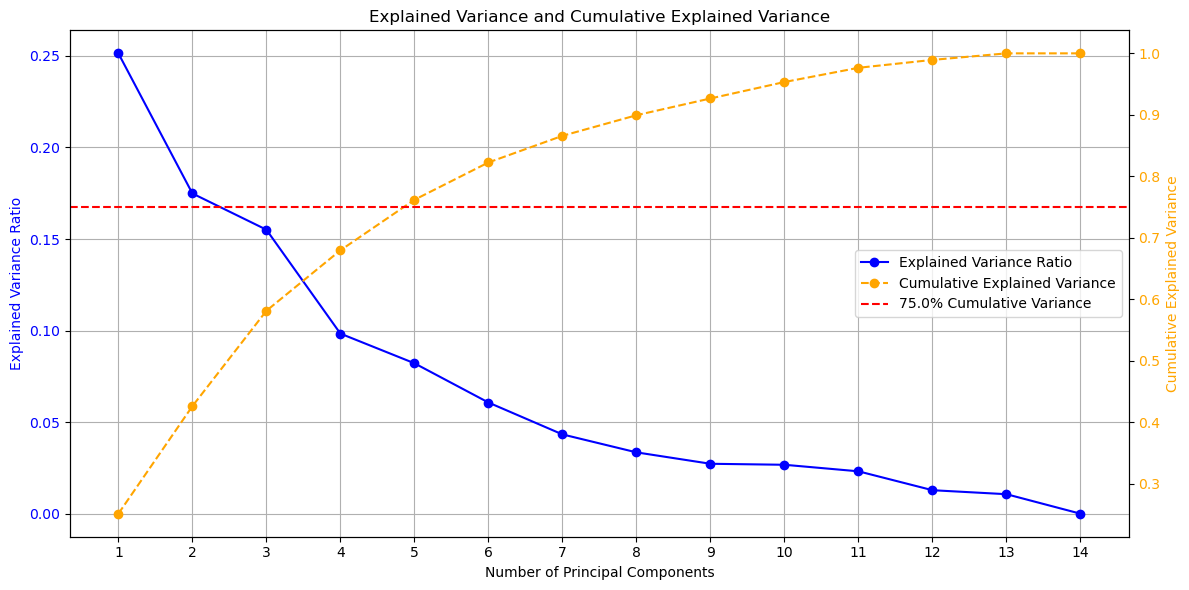

In [16]:
CUMMULATIVE_VARIANCE_THRESHOLD = 0.75
# Convert to a Pandas DataFrame for plotting
explained_variance_pd = explained_variance_df.toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Scree plot (Explained Variance for each component)
line1, = ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 
                  marker='o',  
                  linestyle='-', 
                  color='b', 
                  label='Explained Variance Ratio')
ax1.set_title('Explained Variance and Cumulative Explained Variance')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()

# Create a second y-axis for cumulative variance
line2, = ax2.plot(explained_variance_pd["Component"], explained_variance_pd["Cumulative Variance"], 
                  marker='o', color='orange', linestyle='--', label='Cumulative Explained Variance') 
ax2.set_ylabel('Cumulative Explained Variance', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


line3 = ax2.axhline(y=CUMMULATIVE_VARIANCE_THRESHOLD, color='red', linestyle='--', label=f'{CUMMULATIVE_VARIANCE_THRESHOLD*100}% Cumulative Variance')

# Combine legends
handles = [line1, line2, line3]  # List of handles from both axes
labels = [line1.get_label(), line2.get_label(), f'{CUMMULATIVE_VARIANCE_THRESHOLD*100}% Cumulative Variance']  # Corresponding labels

# Create a single legend
ax1.legend(handles, labels, loc='center right')

plt.xticks(range(1, len(explained_variance_pd) + 1))  # Set x-ticks to be the component numbers
plt.tight_layout()
plt.show()

In [17]:
explained_variance_pd

,Component,Explained Variance Ratio,Cumulative Variance
0,1,0.251389,0.251389
1,2,0.174878,0.426268
2,3,0.155090,0.581358
3,4,0.098352,0.679710
4,5,0.082150,0.761860
5,6,0.060718,0.822578
6,7,0.043306,0.865884
7,8,0.033499,0.899383
8,9,0.027266,0.926648
9,10,0.026722,0.953370


##### 4.1.1. Selecting Number of Components Based on Explained Variance

In [18]:
num_components_explained_variance = explained_variance_pd[explained_variance_pd["Cumulative Variance"] >= CUMMULATIVE_VARIANCE_THRESHOLD].index[0] + 1  # Add 1 because index starts at 0
print(f"Number of components explaining {CUMMULATIVE_VARIANCE_THRESHOLD*100}% of the variance: {num_components_explained_variance}")


Number of components explaining 75.0% of the variance: 5


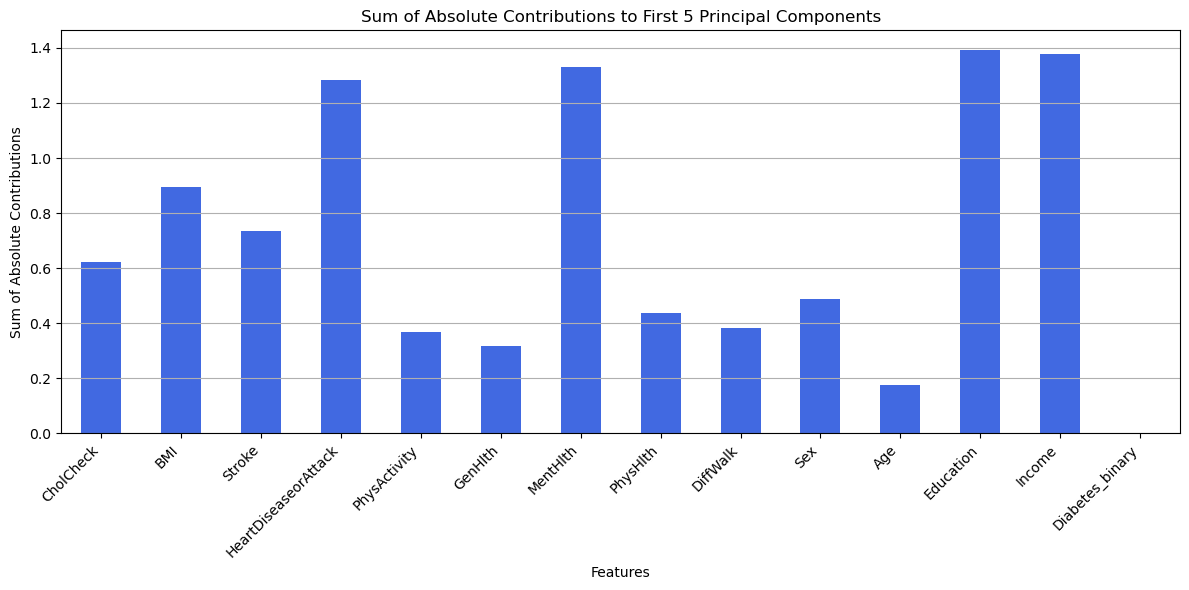

In [19]:
components = pca_model.pc.toArray()

# Create a Pandas-on-Spark DataFrame for feature loadings
feature_loadings_df_ps = ps.DataFrame(components, columns=X_without_created_features.columns)

# Transpose the DataFrame for easier analysis
feature_loadings_df_ps = feature_loadings_df_ps.T
feature_loadings_df_ps.columns = [f'PC{i+1}' for i in range(feature_loadings_df_ps.shape[1])]
feature_loadings_df = feature_loadings_df_ps.to_pandas()

plot_absolute_contributions(feature_loadings_df, num_components_explained_variance)

##### 4.1.2. Selecting Number of Components Base on Elbow Method

In [21]:
num_components_elbow_method = 4
print(f'Based on the elbow method and the plot of the Explained Variance, the number of components should be: {num_components_elbow_method}')

Based on the elbow method and the plot of the Explained Variance, the number of components should be: 4


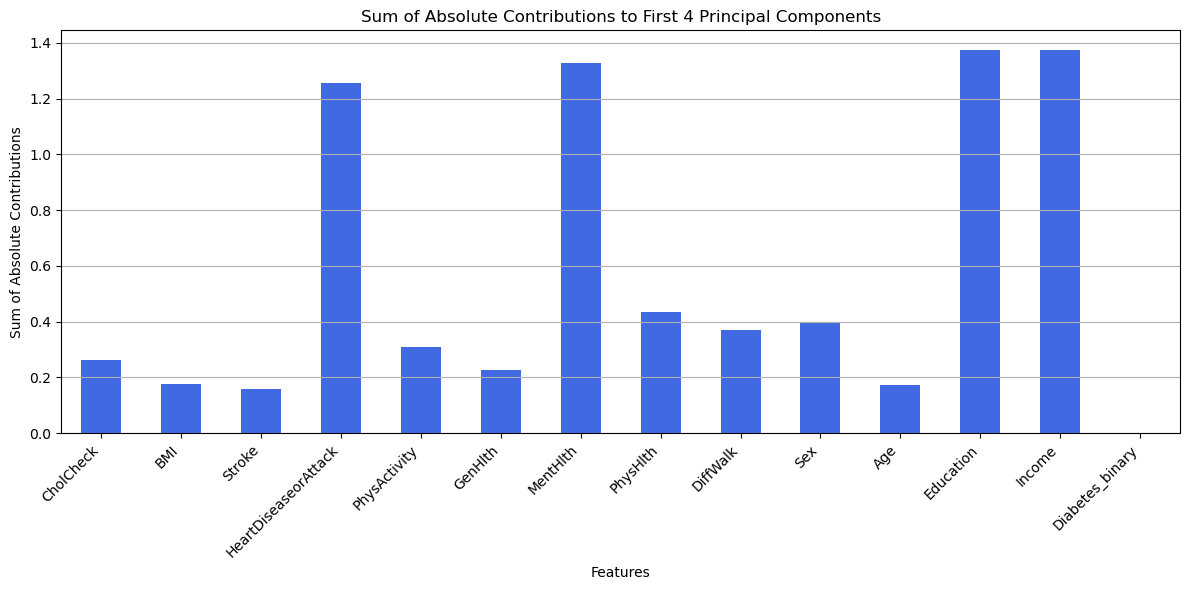

In [22]:
plot_absolute_contributions(feature_loadings_df, num_components_elbow_method)

##### 4.1.3. Correlation between PCA Components and the Initial Features

In [23]:
feature_contribution_df_ps = ps.DataFrame(components, columns=X_without_created_features.columns)

feature_contribution_df_ps = feature_contribution_df_ps.T
feature_contribution_df_ps.columns = [f'PC{i+1}' for i in range(feature_contribution_df_ps.shape[1])]

feature_contribution_df_ps = feature_contribution_df_ps.to_pandas()
feature_contribution_df_ps = feature_contribution_df_ps.round(3)

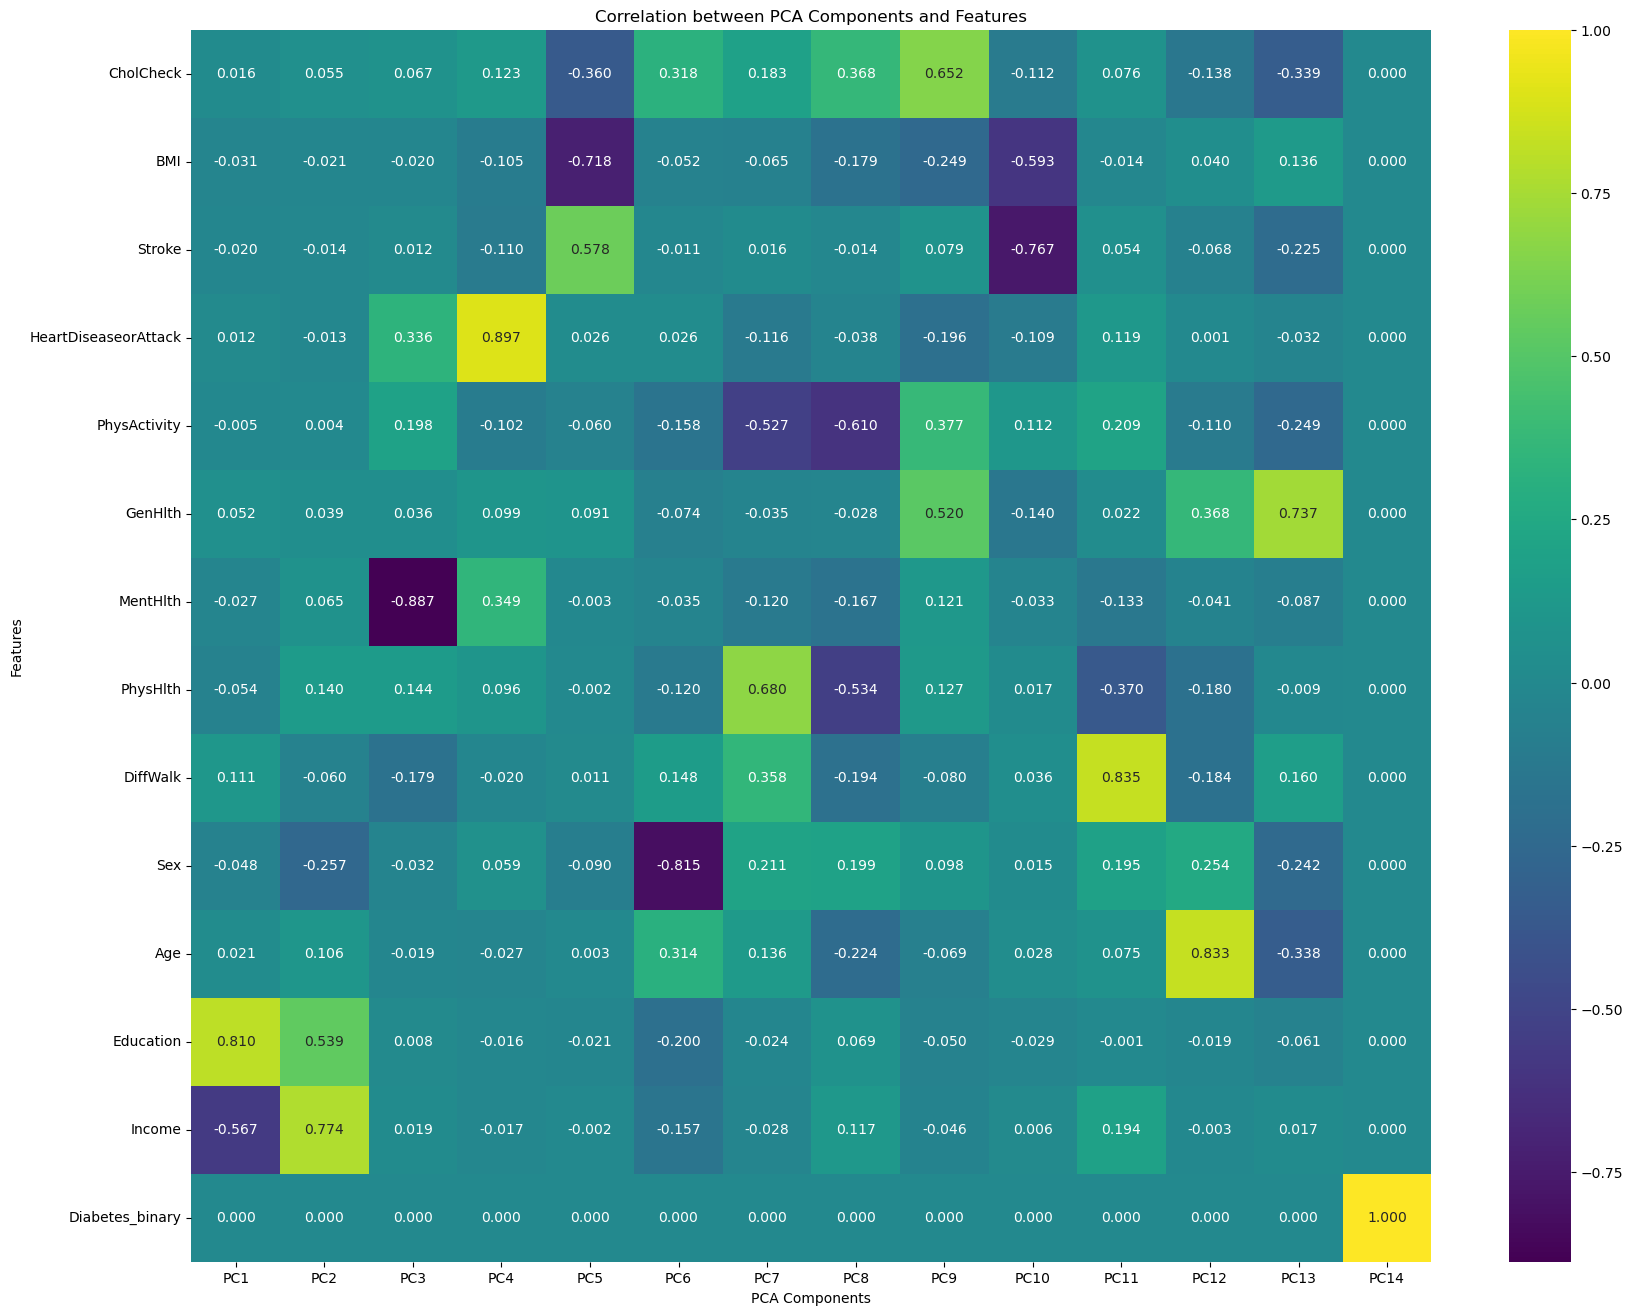

In [24]:
plt.figure(figsize=(20, 16))

sns.heatmap(feature_contribution_df_ps, annot=True, cmap='viridis', fmt='.3f', cbar=True)

plt.title("Correlation between PCA Components and Features")
plt.xlabel("PCA Components")
plt.ylabel("Features")
plt.show()


##### 4.1.4. PCA with 2 Components

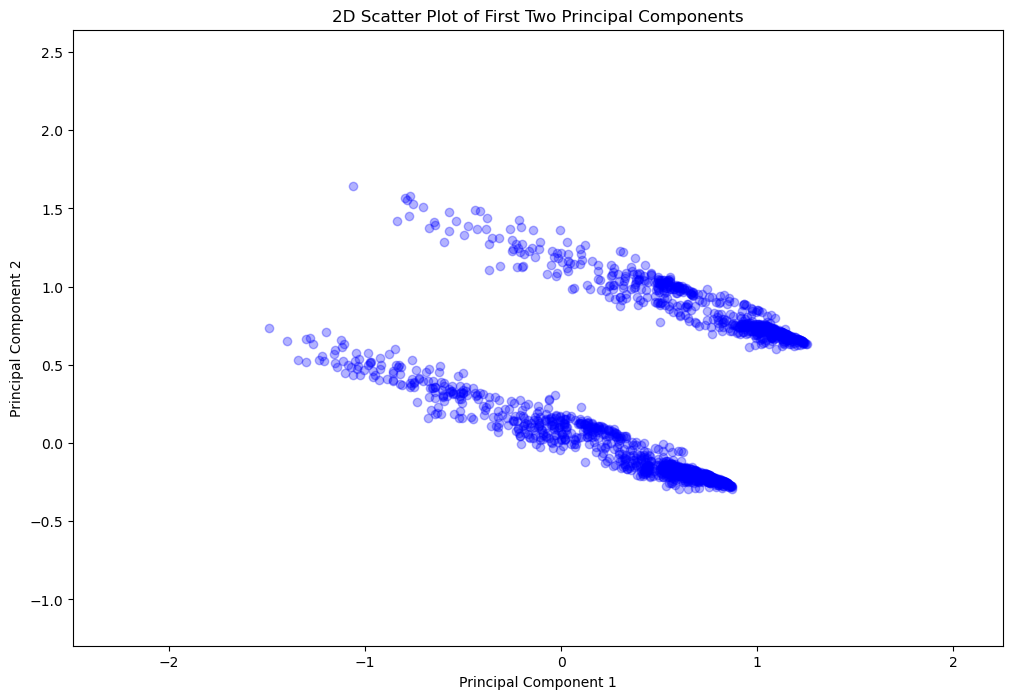

In [40]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features") 
pca_model = pca.fit(X_vector)

X_pca_new = pca_model.transform(X_vector)

pca_features = np.array(X_pca_new.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect())
plot_principal_components(pca_features)


##### 4.1.5. PCA with 3 Components

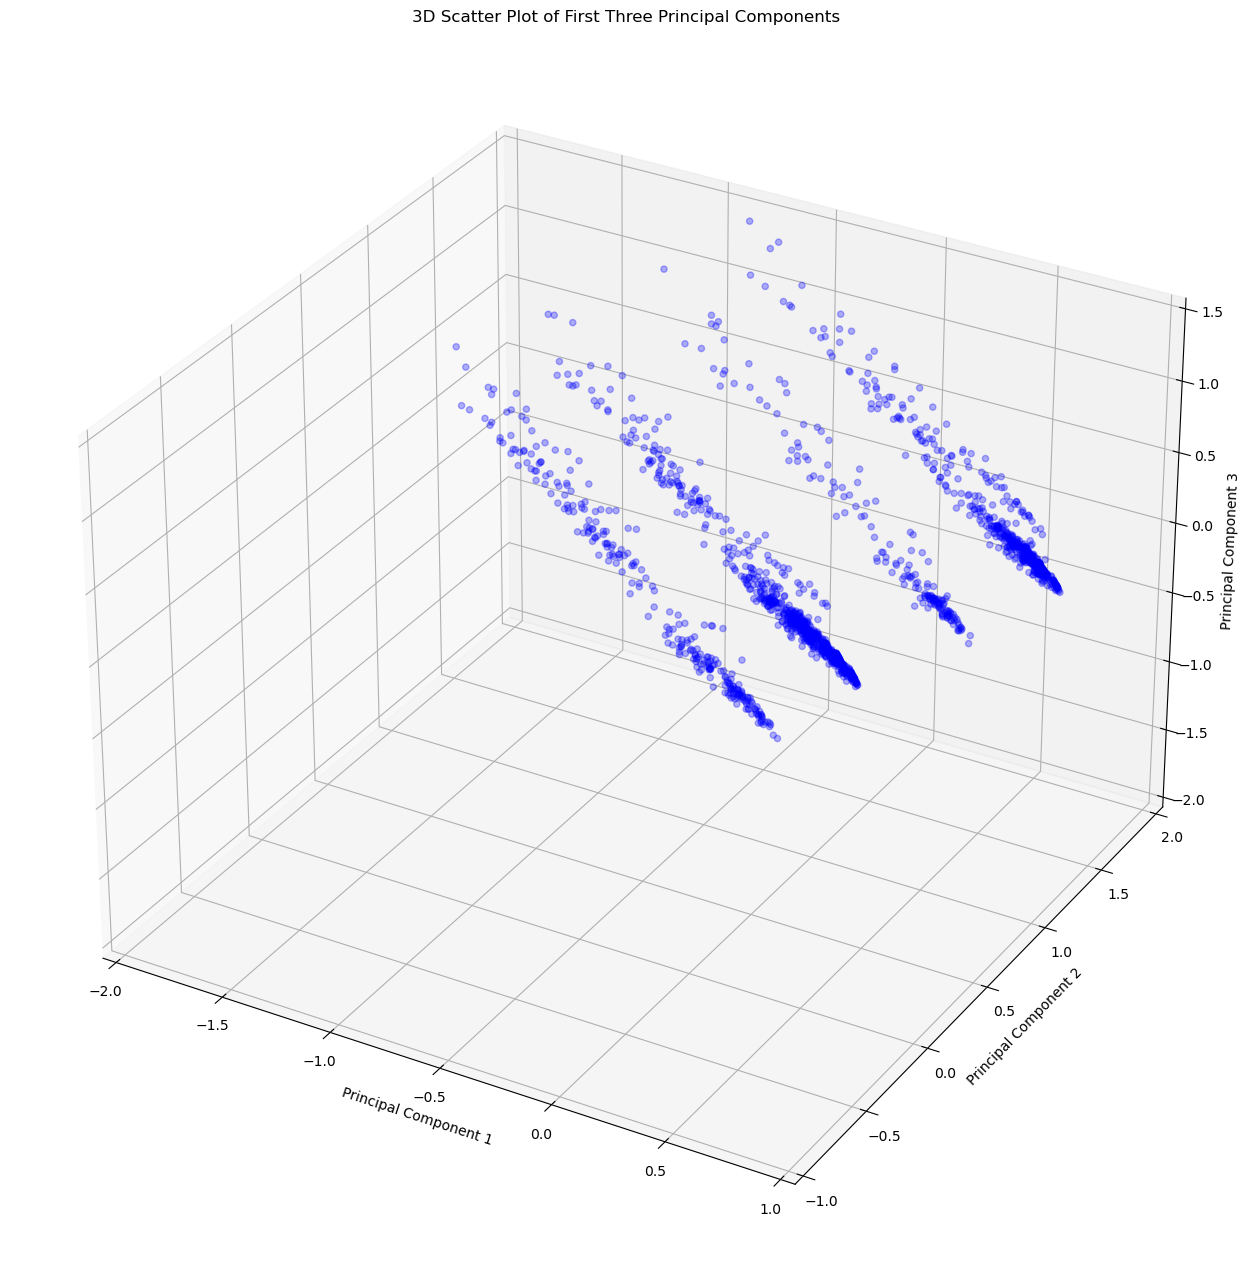

In [41]:
pca = PCA(k=3, inputCol="features", outputCol="pca_features") 
pca_model = pca.fit(X_vector)
X_pca_new = pca_model.transform(X_vector)
pca_features = np.array(X_pca_new.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect())

plot_principal_components_3d(pca_features)


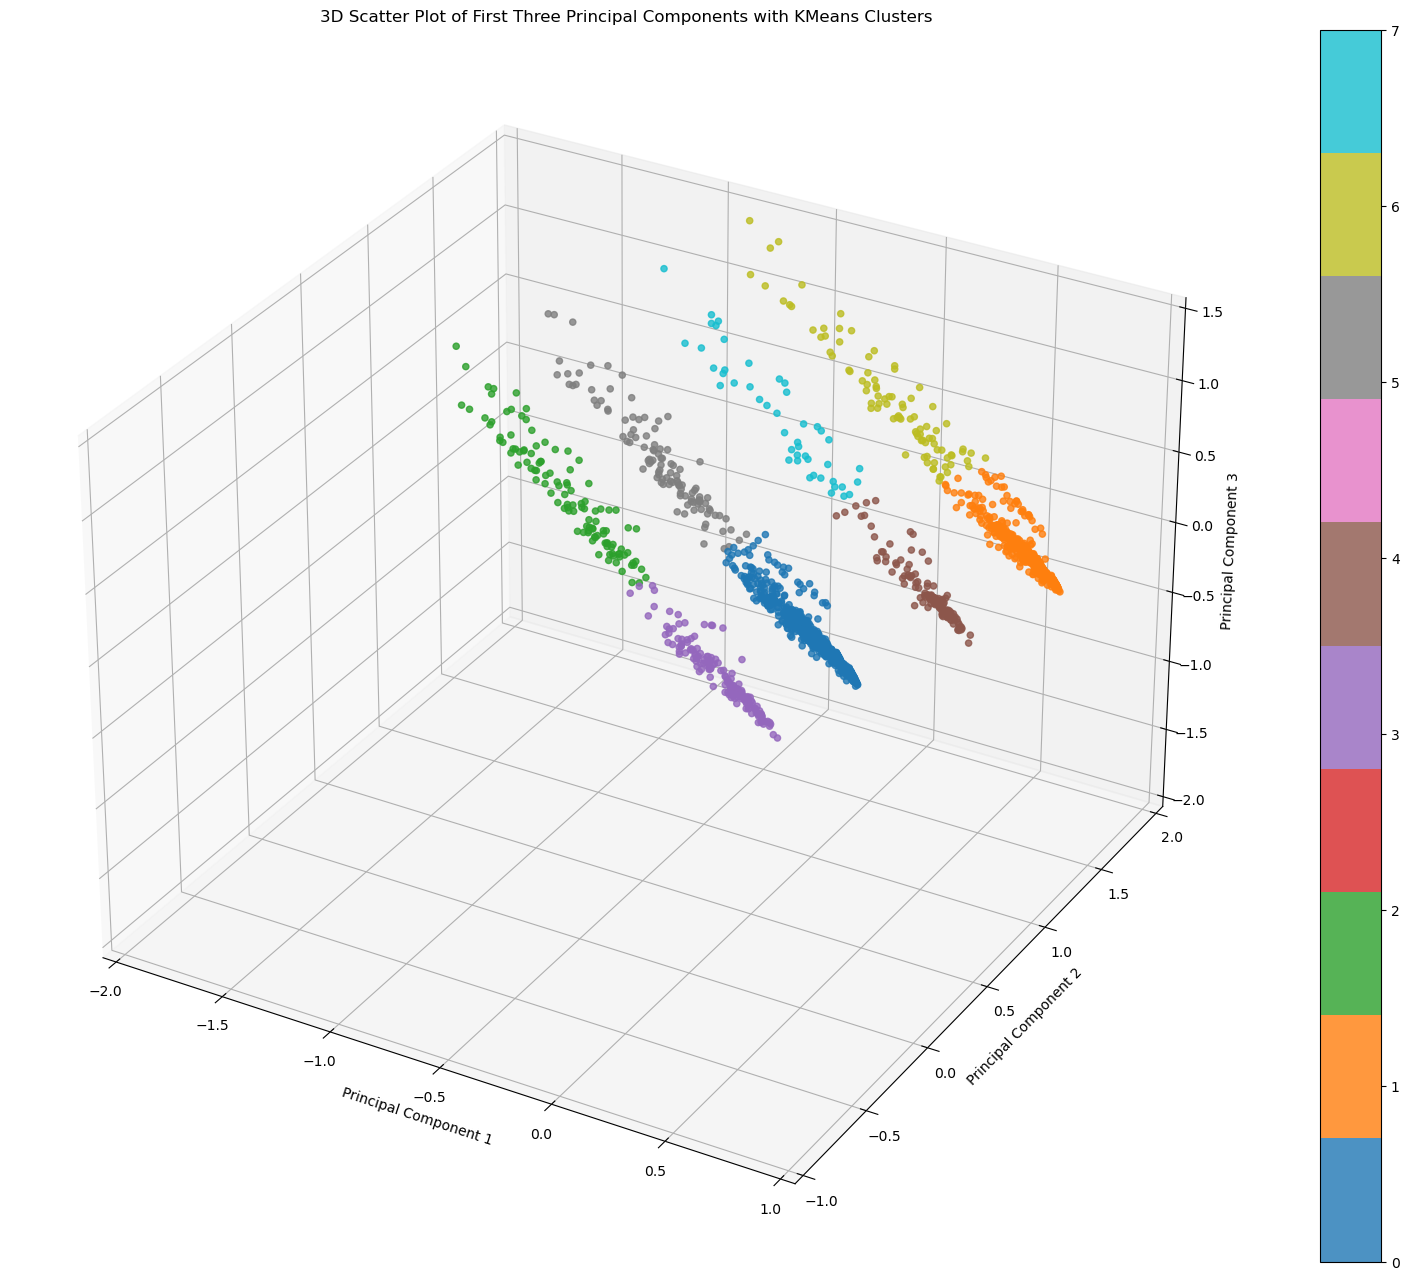

In [44]:
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(pca_features)

plot_pca_with_clusters(pca_features, clusters)

##### 4.1.6. Transforming X based on PCA insights

In [25]:
X_explained_variance_components = pca_filter(X_pyspark.columns[:-4], X_pyspark, num_components_explained_variance)
X_explained_variance_components.show(1)

Selected features based on PCA contributions: ['PhysActivity', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck', 'BMI', 'Diet', 'cardiovascular', 'unhealthy_behavior', 'healthcare']
+------------+--------------------+------+---------+-------------------+----+--------------+------------------+----------+
|PhysActivity|HeartDiseaseorAttack|Stroke|CholCheck|                BMI|Diet|cardiovascular|unhealthy_behavior|healthcare|
+------------+--------------------+------+---------+-------------------+----+--------------+------------------+----------+
|           1|                   0|     0|        1|0.27906976744186046| 0.5|           1.0|               0.5|       1.0|
+------------+--------------------+------+---------+-------------------+----+--------------+------------------+----------+
only showing top 1 row



In [26]:
X_elbow_method_components = pca_filter(X_pyspark.columns[:-4], X_pyspark, num_components_elbow_method)
X_elbow_method_components.show(1)

Selected features based on PCA contributions: ['HeartDiseaseorAttack', 'Stroke', 'BMI', 'CholCheck', 'Diet', 'cardiovascular', 'unhealthy_behavior', 'healthcare']
+--------------------+------+-------------------+---------+----+--------------+------------------+----------+
|HeartDiseaseorAttack|Stroke|                BMI|CholCheck|Diet|cardiovascular|unhealthy_behavior|healthcare|
+--------------------+------+-------------------+---------+----+--------------+------------------+----------+
|                   0|     0|0.27906976744186046|        1| 0.5|           1.0|               0.5|       1.0|
+--------------------+------+-------------------+---------+----+--------------+------------------+----------+
only showing top 1 row



In [27]:
X_no_compound_features = X_with_all_features.drop('Diet', 'cardiovascular', 'unhealthy_behavior', 'healthcare')
X_no_compound_features = pca_filter(X_no_compound_features.columns[:-4], X_no_compound_features, 10, add_composite_features=False)
X_no_compound_features.show(1)

Selected features based on PCA contributions: ['Fruits', 'Smoker', 'Veggies', 'HighBP', 'HighChol', 'PhysActivity', 'HeartDiseaseorAttack', 'Stroke', 'CholCheck', 'BMI']
+------+------+-------+------+--------+------------+--------------------+------+---------+-------------------+
|Fruits|Smoker|Veggies|HighBP|HighChol|PhysActivity|HeartDiseaseorAttack|Stroke|CholCheck|                BMI|
+------+------+-------+------+--------+------------+--------------------+------+---------+-------------------+
|     0|     1|      1|     1|       1|           1|                   0|     0|        1|0.27906976744186046|
+------+------+-------+------+--------+------------+--------------------+------+---------+-------------------+
only showing top 1 row



#### 4.2. Factor Analysis

In [45]:
X_pd = X_pyspark.toPandas()
chi_square_value, p_value = calculate_bartlett_sphericity(X_pd)
print(f"Bartlett's Test: Chi-square = {chi_square_value:.4f}, p-value = {p_value:.4f}")

Bartlett's Test: Chi-square = 24558.7198, p-value = 0.0000


In [46]:
_,kmo_model=calculate_kmo(X_pd)
print(f'The Kaiser-Meyer-Olkin (KMO) measure is {kmo_model}.')

The Kaiser-Meyer-Olkin (KMO) measure is 0.7747365208982252.


It is an acceptable value and the dataset is suitable for a factor analysis.

In [47]:
fa = FactorAnalyzer(n_factors=15)
fa.fit(X_pd)

FactorAnalyzer(n_factors=15, rotation_kwargs={})

In [48]:
loadings = fa.loadings_  # The factor loadings matrix from factor analysis
variable_names = X_pd.columns  # The names of the variables used in the analysis

loadings_df = ps.DataFrame(
    loadings, 
    columns=[f'Factor {i+1}' for i in range(loadings.shape[1])],
    index=variable_names
)
loadings_df.head(25)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
CholCheck,-0.007360,-0.021116,0.004301,-0.022295,0.031423,-0.007461,0.005234,0.006056,0.007181,-0.006350,0.006798,0.007497,-0.004790,0.435994,-0.007417
BMI,-0.048828,-0.040576,-0.004865,0.741420,0.077059,-0.030328,0.065497,0.047452,0.034686,-0.040152,0.033122,-0.027608,-0.016936,-0.026919,-0.019274
Stroke,0.000130,0.009155,-0.003992,0.003045,-0.008058,0.456768,0.006623,0.003202,0.000421,-0.001797,0.000384,-0.009742,0.000759,0.004553,-0.078675
HeartDiseaseorAttack,-0.019666,-0.021586,0.002226,-0.043731,0.047583,0.467611,0.025014,0.019553,0.016638,-0.017419,0.015901,-0.001813,-0.009300,-0.018704,0.237748
PhysActivity,-0.044743,-0.008050,-0.009262,-0.045914,0.031620,-0.017503,0.051776,0.044891,0.021449,0.510684,0.020639,-0.034748,-0.008829,-0.007859,-0.007466
GenHlth,0.437515,0.020001,0.005959,0.088318,-0.060461,0.039976,-0.090909,-0.061494,-0.038954,0.047138,0.484679,0.058858,0.016285,0.016002,0.014398
MentHlth,0.504794,-0.055106,0.037034,0.024748,0.017829,0.014591,-0.102716,-0.061021,-0.026905,0.040384,-0.054461,0.107559,0.004341,-0.023236,-0.007773
PhysHlth,0.977105,0.019909,-0.048236,-0.115058,0.056031,-0.047583,0.185153,0.117895,0.066143,-0.090579,0.063322,-0.148863,-0.022792,-0.001864,-0.011550
DiffWalk,0.284237,0.022868,0.007204,0.065835,-0.051294,0.032308,-0.064083,-0.043921,0.554417,0.028937,-0.027834,0.037395,0.012807,0.015316,0.012466
Sex,0.056677,-0.001983,0.021290,0.061422,-0.035788,0.025382,0.577321,-0.057976,-0.033232,0.043747,-0.031940,0.070410,0.012280,0.005029,0.007911


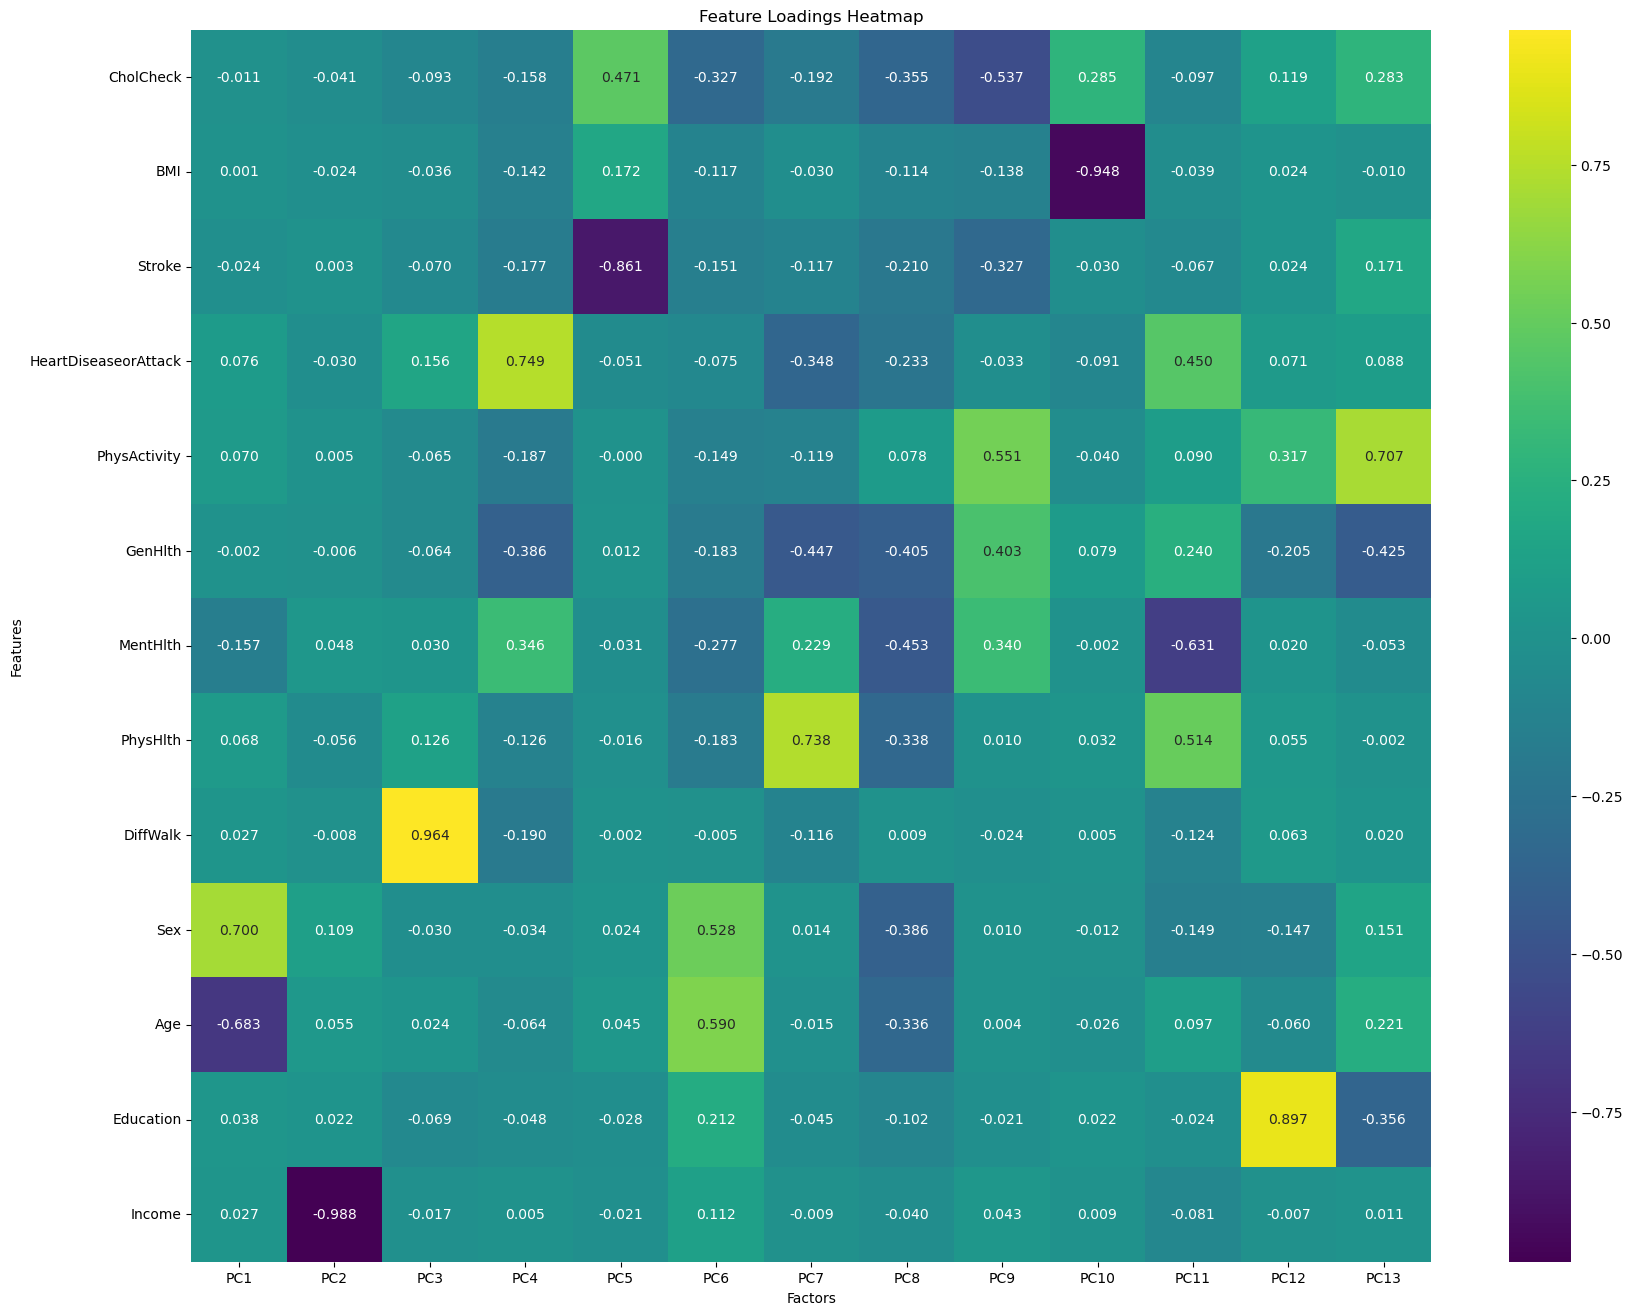

In [49]:
plt.figure(figsize=(20, 16))

sns.heatmap(feature_loadings_df, annot=True, cmap='viridis', fmt='.3f', cbar=True)

plt.title("Feature Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Features")

plt.show()


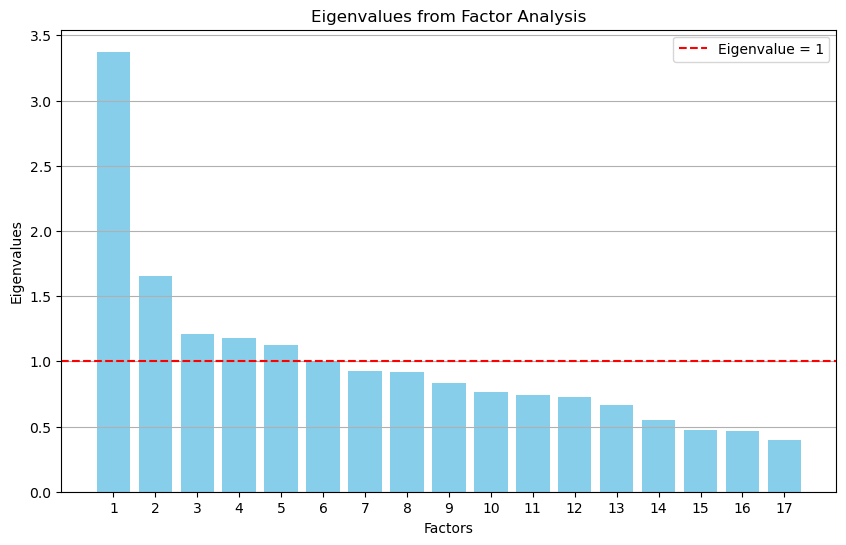

In [50]:
ev, v = fa.get_eigenvalues()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ev) + 1), ev, color='skyblue')
plt.title('Eigenvalues from Factor Analysis')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.xticks(range(1, len(ev) + 1))  # Set x-ticks to factor numbers
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.legend()
plt.grid(axis='y')
plt.show()

## **5.Machine Learning Algorithms**

In [28]:
datasets = {}

In [29]:
datasets['explained_variance'] = test_train_split(X_explained_variance_components, y_pyspark)
datasets['elbow_method'] = test_train_split(X_elbow_method_components, y_pyspark)
datasets['no_compound_features'] = test_train_split(X_no_compound_features, y_pyspark)

In [30]:
results = {"explained_variance":{}, "elbow_method":{}, "no_compound_features":{}}

### 5.1. Training

In [31]:
models = {}

In [32]:
models['lr'] = LogisticRegression(
    featuresCol="features",          
    labelCol="Diabetes_binary",      
    regParam=0.1,                    
    elasticNetParam=0.0,             
    family="binomial",               
    maxIter=500                     
)
models['dt'] = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, minInstancesPerNode=2)
models['rf'] = RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=10, minInstancesPerNode=5, numTrees=100)
models['gbt'] = GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxDepth=5, maxIter=50, stepSize=0.1)
models['nb'] = NaiveBayes(labelCol="Diabetes_binary", featuresCol="features")
models['svm'] = LinearSVC(labelCol="Diabetes_binary", featuresCol="features")
models['mlp'] = MultilayerPerceptronClassifier(labelCol="Diabetes_binary", featuresCol="features", layers=[10,100,2], seed=1234, stepSize=0.01)

In [33]:
param_grids = {
    'lr': (ParamGridBuilder()
           .addGrid(models['lr'].regParam, [0.01, 0.1, 0.5])
           .addGrid(models['lr'].maxIter, [100, 250, 500])
           .build()),
    
    'dt': (ParamGridBuilder()
           .addGrid(models['dt'].maxDepth, [3, 5, 8])
           .addGrid(models['dt'].minInstancesPerNode, [2, 5])
           .build()),
    
    'rf': (ParamGridBuilder()
           .addGrid(models['rf'].maxDepth, [3, 5, 8])
           .addGrid(models['rf'].numTrees, [5, 10])
           .build()),
    
    'gbt': (ParamGridBuilder()
            .addGrid(models['gbt'].maxDepth, [3, 5, 8])
            .addGrid(models['gbt'].maxIter, [5, 10])
            .build()),
    
    'nb': (ParamGridBuilder()
           .addGrid(models['nb'].smoothing, [0.1, 1.0, 10.0])
           .build()),
    
    'svm': (ParamGridBuilder()
            .addGrid(models['svm'].regParam, [0.01, 0.1, 1.0])
            .build()),
    
    'mlp': (ParamGridBuilder()
            .addGrid(models['mlp'].layers, [[10, 50, 2], [10, 100, 2], [10, 25, 25, 2]])
            .addGrid(models['mlp'].stepSize, [0.01, 0.1])
            .build())
}

models_name_mapping = {
    'lr': 'Logistic Regression', 
    'dt': 'Decision Tree Classifier', 
    'rf': 'Random Forest Classifier', 
    'gbt': 'Gradient-Boosted Tree Classifier', 
    'nb': 'Naive Bayes Classifier', 
    'svm': 'Linear Support Vector Machine (SVM)', 
    'mlp': 'Multilayer Perceptron Classifier'
}


In [34]:
for dataset_name, dataset in datasets.items():
    for model_name, model in models.items():
        if model_name == 'mlp':
            train_data,_ = dataset
            features_number = len(train_data.columns) - 2
            param_grids['mlp'] = (ParamGridBuilder()
            .addGrid(models['mlp'].layers, [[features_number, 50, 2], [features_number, 100, 2], [features_number, 25, 25, 2]])
            .addGrid(models['mlp'].stepSize, [0.01, 0.1])
            .build())
        start = time()
        print(f'Training model {models_name_mapping[model_name]} on dataset {dataset_name}')
        results[dataset_name][model_name] = fit_and_test(model, *dataset, model_name, param_grids[model_name])
        print(f'Training finished in {time()-start} seconds\n\n')

Training model Logistic Regression on dataset explained_variance


KeyboardInterrupt: 

### 5.2. Results comparison

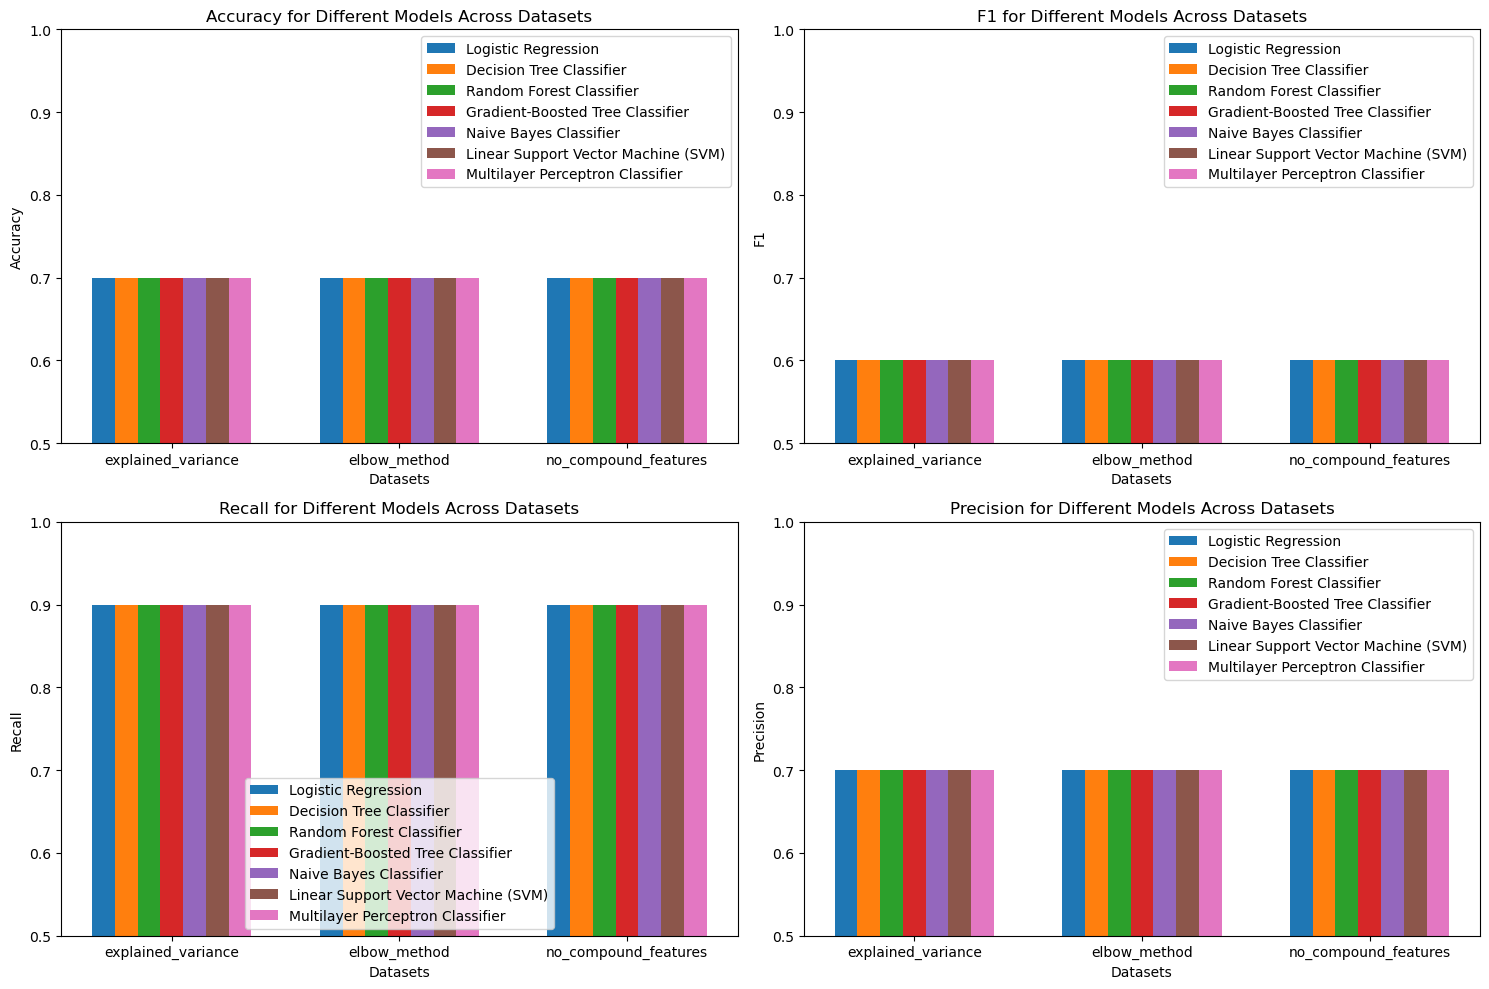

In [36]:
plot_models_results(results, models_name_mapping)